# Initial Experiments with the CPAC10S_S02_S03 dataset

## Libraries

In [1]:
import sklearn
assert sklearn.__version__ >= "0.21", "Use the conda_python3_latest kernel!"

# Standard library
import os
import re
import warnings

# Third party
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
from sklearn import (dummy, linear_model, ensemble, 
                     metrics, preprocessing, pipeline, inspection, 
                     model_selection)

# Local
import utils

# matplotlib hackery
%matplotlib inline

## Load Dataset

In [2]:
df_orig = utils.load_dataset("s3://cpac/ORIG/CPAC_S02_S03_05_26_20/CPAC10S_S02_S03_05_26_20.csv")
df_orig.describe()

M_Trial_Num         M_Mass  M_Mass_to_L5S1  M_sub_task_indices  \
count  363815.000000  363815.000000   288738.000000       363815.000000   
mean       68.079216      10.486291        0.307655          265.108517   
std        22.686262       5.744458        0.162560          197.355745   
min         1.000000       0.000000        0.083662            1.000000   
25%        51.000000       5.000000        0.155201          116.000000   
50%        77.000000      10.000000        0.269868          232.000000   
75%        85.000000      15.000000        0.453899          370.000000   
max        96.000000      23.000000        0.701759         1589.000000   

       M_sub_task_num  M_include_overall        M_Index          M_Sub  \
count   363815.000000      363815.000000  363815.000000  363815.000000   
mean         5.624807           0.846394    2713.826898       2.473021   
std          4.801182           0.360571    2506.578760       0.499272   
min          1.000000           0.000000       1.000000       2.000000   
25%          1.000000           1.000000     583.000000       2.000000   
50%          4.000000           1.000000    1909.000000       2.000000   
75%          9.000000           1.000000    4304.000000       3.000000   
max         18.000000           1.000000   11317.000000       3.000000   

       M_sub_task_num_overall  M_Index_overall  ...  \
count           363815.000000    363815.000000  ...   
mean               223.563355     50517.296391  ...   
std                116.207719     62489.322519  ...   
min                  1.000000        -0.195016  ...   
25%                127.000000         0.000000  ...   
50%                233.000000      9816.000000  ...   
75%                319.000000    100769.500000  ...   
max                429.000000    191723.000000  ...   

       RWEO_03_04_00_00_INSOLE_LY_AP_threshF50_mm  \
count                               330242.000000   
mean                                   117.304437   
std                                     46.379116   
min                                      0.000000   
25%                                     81.410000   
50%                                    112.070000   
75%                                    153.220000   
max                                    242.320000   

       RWEO_01_00_00_00_INSOLE_RFORCE_threshF50_N  \
count                               363794.000000   
mean                                   445.347758   
std                                    301.023338   
min                                      0.000000   
25%                                    181.055000   
50%                                    449.021000   
75%                                    649.837250   
max                                   1558.065000   

       RWEO_01_02_00_00_INSOLE_RX_ML_threshF50_mm  \
count                               326972.000000   
mean                                    49.239987   
std                                      7.994325   
min                                      0.000000   
25%                                     45.620000   
50%                                     51.030000   
75%                                     54.650000   
max                                     71.260000   

       RWEO_01_02_00_00_INSOLE_RY_AP_threshF50_mm  \
count                               326972.000000   
mean                                   134.553623   
std                                     46.350097   
min                                      0.000000   
25%                                    103.770000   
50%                                    133.120000   
75%                                    172.780000   
max                                    247.560000   

       RWEF_03_00_00_00_INSOLE_LFORCE_threshF50_BW  \
count                                363794.000000   
mean                                      0.537672   
std                                       0.333517   
min                                       

## Associate column names

In [3]:
def _get_columns_with_prefix(df, prefix):
    columns = []
    for column in df.columns:
        if column.startswith(prefix):
            columns.append(column)
    return columns
    
def get_target_names(df):
    return _get_columns_with_prefix(df, "T_")

def get_meta_names(df):
    return _get_columns_with_prefix(df, "M_")    

## Clean-up dataset

- Remove samples based on `M_include_overall`

In [4]:
df = df_orig[df_orig["M_include_overall"] > 0]
print(f"Number of samples: {df.shape[0]} (before clean-up: {df_orig.shape[0]})")
print(f"Number of trials: {len(df['M_Trial_Name'].unique())} (before clean-up: {len(df_orig['M_Trial_Name'].unique())})", )

Number of samples: 307931 (before clean-up: 363815)
Number of trials: 127 (before clean-up: 129)


## Predictor configurations (recipes)

In [5]:
def predictor_short_name(predictor):
    return predictor[17:]

def predictor_sensor_number(predictor):
    return int(predictor[5:7])

def filter_predictors(all_predictors, patterns):
    if isinstance(patterns, str):
        patterns = (patterns,)
        
    predictors = []
    for predictor in all_predictors:
        for pattern in patterns:
            if pattern in predictor:
                predictors.append(predictor)
                break
    return predictors


feature_sets = {
    "Recipe 1: Simulated Wearable - All Regular": 
        filter_predictors(df.columns, "SWRF"),
    
    "Recipe 2: Simulated Wearable - All Regular & Exploratory": 
        filter_predictors(df.columns, ("SWRF", "SWEF")),
    
    "Recipe 3: Real Wearable - All Regular": 
        filter_predictors(df.columns, "RWRF"),
    
    "Recipe 4: Real Wearable - All Regular & Exploratory": 
        filter_predictors(df.columns, ("RWRF", "RWEF")),
    
    "Recipe 5: Real Wearable - Insole Only":
        filter_predictors(
            filter_predictors(df.columns, ("RWRF", "RWEF")),
            ("03_00_00_00", "01_00_00_00", "03_04_00_00", "01_02_00_00", "01_03_00_00")
        ),
    
    "Recipe 6: Real Wearable - Trunk Orientatoin Only":
        filter_predictors(
            filter_predictors(df.columns, ("RWRF", "RWEF")),
            ("12_00_00_00",)
        ),
    
    "Recipe 7: Real Wearable - Insole & Trunk Orientation":
        filter_predictors(
            filter_predictors(df.columns, ("RWRF", "RWEF")),
            ("03_00_00_00", "01_00_00_00", "03_04_00_00", "01_02_00_00", "01_03_00_00", 
             "12_00_00_00", "01_03_12_00")
        ),
    
    "Recipe 8: Real Wearable - Insole & Hip Angles & Trunk Orientation":
        filter_predictors(
            filter_predictors(df.columns, ("RWRF", "RWEF")),
            ("03_00_00_00", "01_00_00_00", "03_04_00_00", "01_02_00_00", "01_03_00_00", 
             "12_00_00_00", "01_03_12_00",
             "05_06_00_00", "05_09_00_00", "06_00_00_00", "09_00_00_00", "05_12_00_00", "05_06_01_03", "05_09_01_03")
        ),
    
}

for feature_set_name, predictors in feature_sets.items():
    sensors = set(map(predictor_sensor_number, predictors))
    print(f"{feature_set_name}\n\tPredictors: {len(predictors)}, Sensors: {len(sensors)}\n")

Recipe 1: Simulated Wearable - All Regular
	Predictors: 75, Sensors: 10

Recipe 2: Simulated Wearable - All Regular & Exploratory
	Predictors: 104, Sensors: 10

Recipe 3: Real Wearable - All Regular
	Predictors: 166, Sensors: 10

Recipe 4: Real Wearable - All Regular & Exploratory
	Predictors: 201, Sensors: 10

Recipe 5: Real Wearable - Insole Only
	Predictors: 17, Sensors: 2

Recipe 6: Real Wearable - Trunk Orientatoin Only
	Predictors: 56, Sensors: 1

Recipe 7: Real Wearable - Insole & Trunk Orientation
	Predictors: 77, Sensors: 3

Recipe 8: Real Wearable - Insole & Hip Angles & Trunk Orientation
	Predictors: 133, Sensors: 6



## Train/Test configurations


In [6]:
target_name = "TF_Pelvis_Moment_X_BWBH"

test_selectors = {
    "Subject 2 -> Subject 3": df["M_Sub"] == 3,
    "Subject 3 -> Subject 2": df["M_Sub"] == 2,
    "Subject 2 & 3 -> 5kg Test": df["M_Trial_Name"].str.match("S0[0-9]_5kg")
}

train_test_sets = {}
for test_selector_name, test_selector in test_selectors.items():
    for target_limit in -np.inf, -0.20:
        df_train, df_test = df[~test_selector].dropna(), df[test_selector].dropna()
        train_test_set_name = test_selector_name
        if np.isfinite(target_limit):
            train_test_set_name += f", target > {target_limit}"
            df_train = df_train[df_train[target_name] > target_limit]
            df_test = df_test[df_test[target_name] > target_limit]
        train_test_sets[train_test_set_name] = (df_train, df_test)
        print(f"{train_test_set_name}: {len(df_train)}/{len(df_test)} "
              f"({len(df_train) / len(df):.1%}/{len(df_test) / len(df):.1%})")

Subject 2 -> Subject 3: 106652/67581 (34.6%/21.9%)
Subject 2 -> Subject 3, target > -0.2: 106366/67581 (34.5%/21.9%)
Subject 3 -> Subject 2: 67581/106652 (21.9%/34.6%)
Subject 3 -> Subject 2, target > -0.2: 67581/106366 (21.9%/34.5%)
Subject 2 & 3 -> 5kg Test: 159901/14332 (51.9%/4.7%)
Subject 2 & 3 -> 5kg Test, target > -0.2: 159615/14332 (51.8%/4.7%)


## Train and evaluate boosted tree models

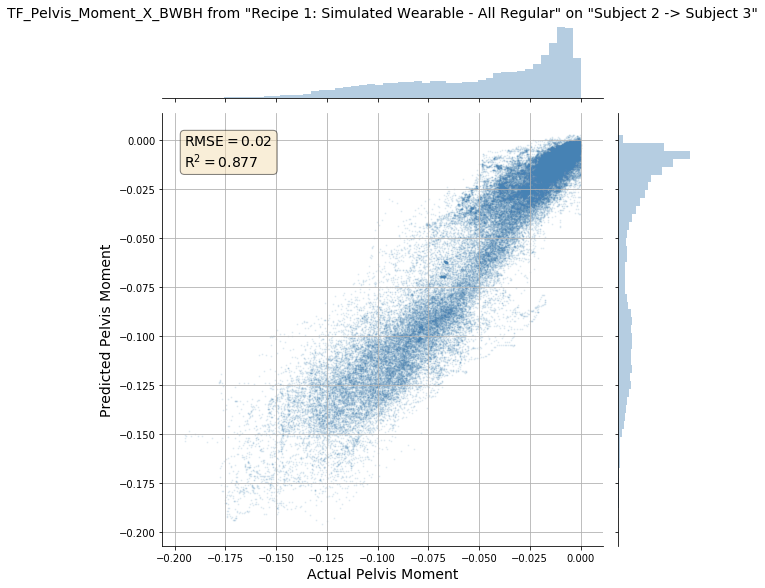

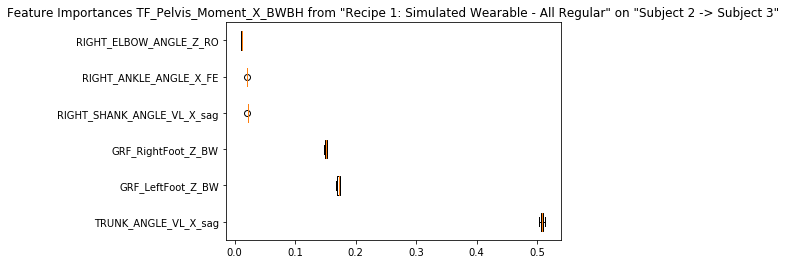

TF_Pelvis_Moment_X_BWBH from "Recipe 1: Simulated Wearable - All Regular" on "Subject 2 -> Subject 3"
	R2=0.877


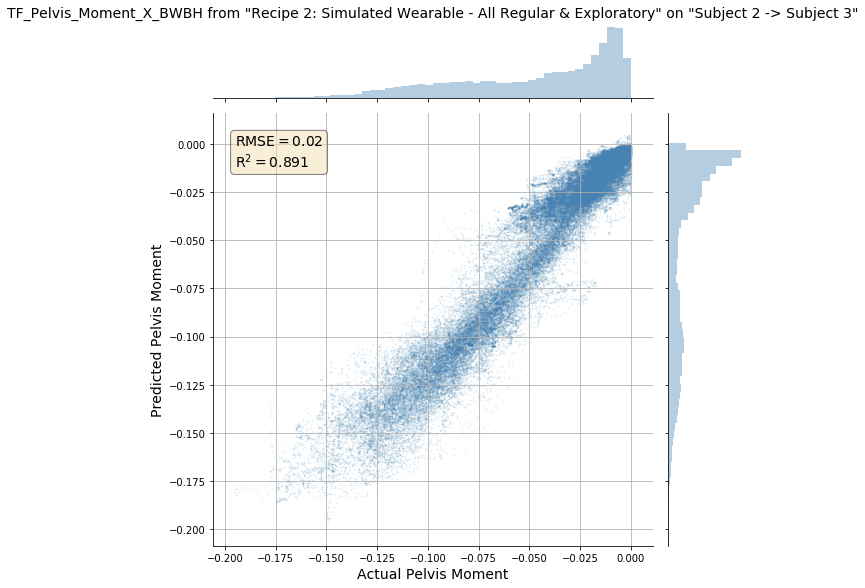

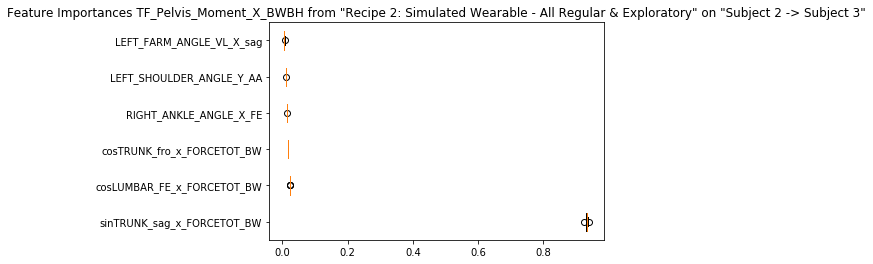

TF_Pelvis_Moment_X_BWBH from "Recipe 2: Simulated Wearable - All Regular & Exploratory" on "Subject 2 -> Subject 3"
	R2=0.891


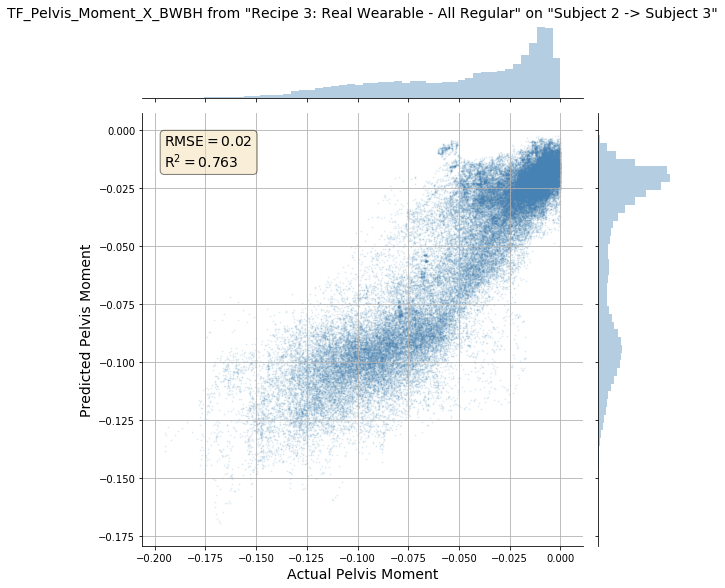

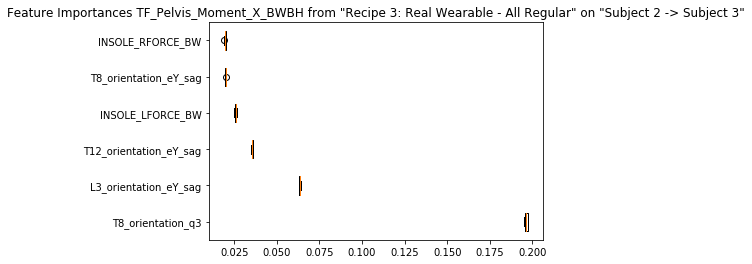

TF_Pelvis_Moment_X_BWBH from "Recipe 3: Real Wearable - All Regular" on "Subject 2 -> Subject 3"
	R2=0.763


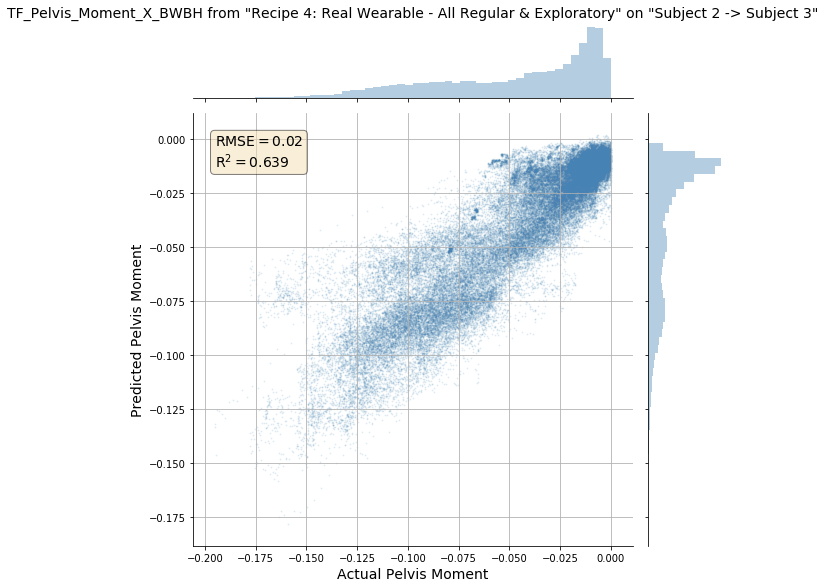

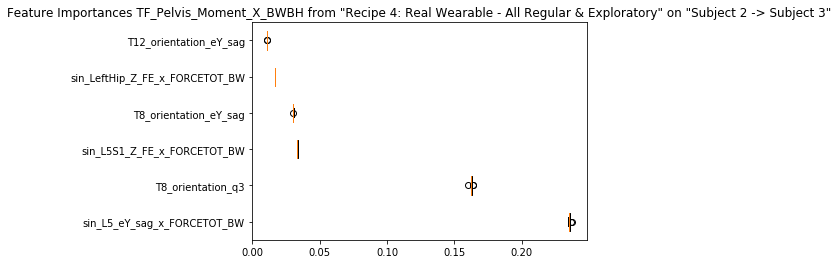

TF_Pelvis_Moment_X_BWBH from "Recipe 4: Real Wearable - All Regular & Exploratory" on "Subject 2 -> Subject 3"
	R2=0.639


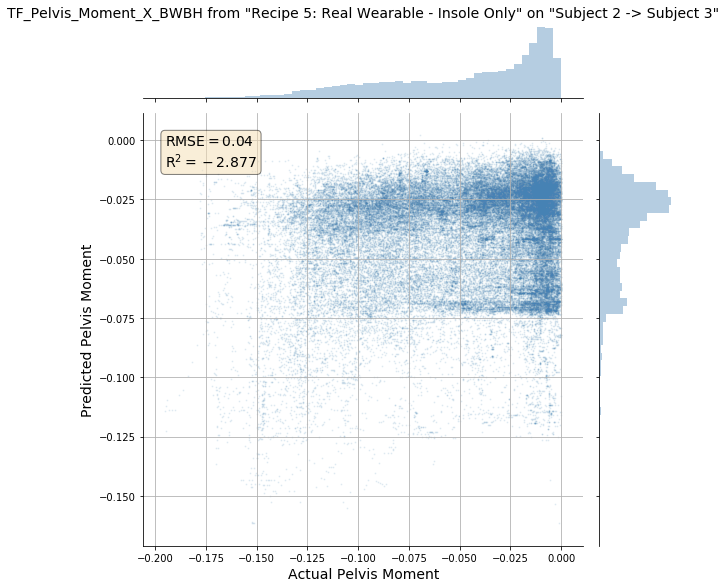

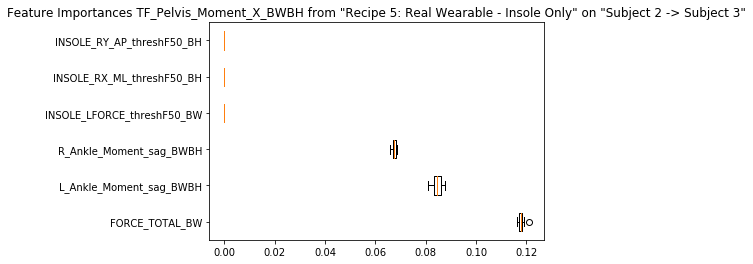

TF_Pelvis_Moment_X_BWBH from "Recipe 5: Real Wearable - Insole Only" on "Subject 2 -> Subject 3"
	R2=-2.877


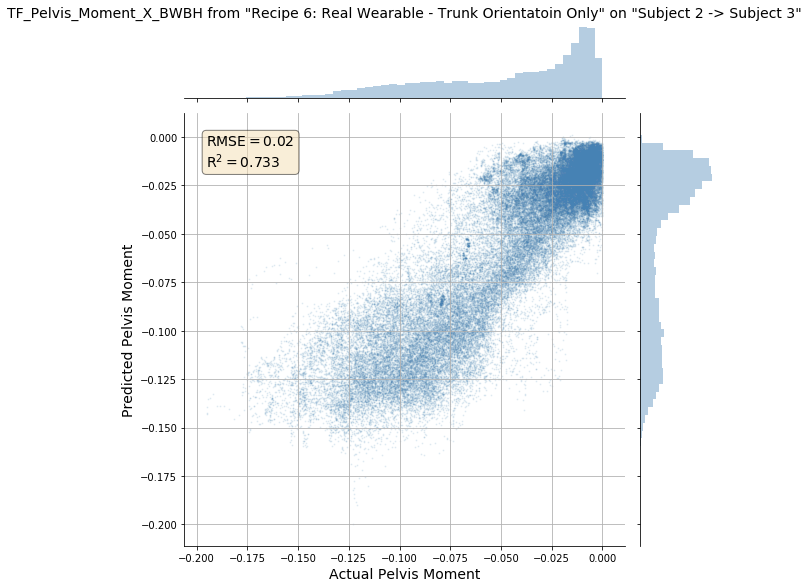

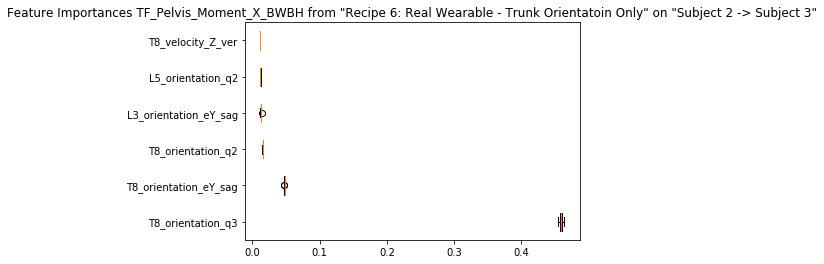

TF_Pelvis_Moment_X_BWBH from "Recipe 6: Real Wearable - Trunk Orientatoin Only" on "Subject 2 -> Subject 3"
	R2=0.733


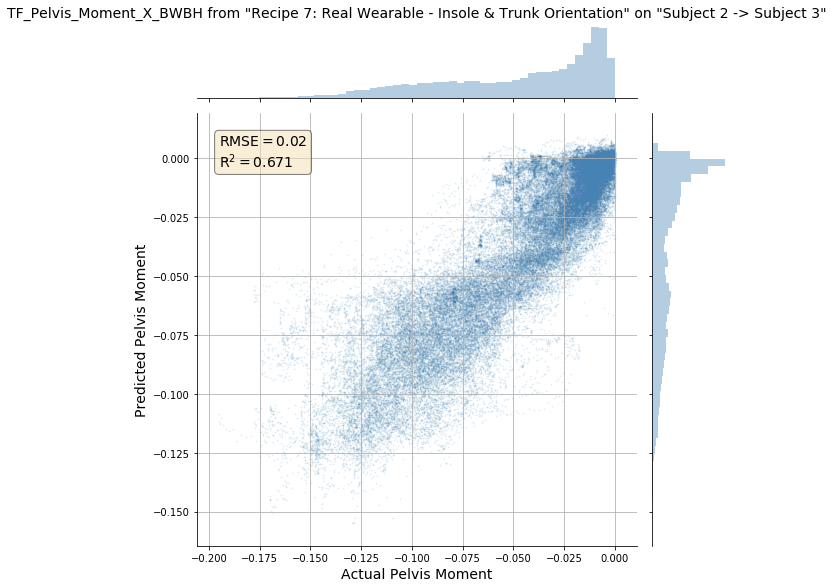

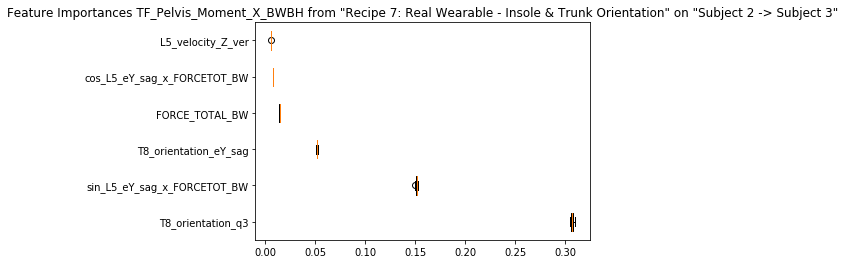

TF_Pelvis_Moment_X_BWBH from "Recipe 7: Real Wearable - Insole & Trunk Orientation" on "Subject 2 -> Subject 3"
	R2=0.671


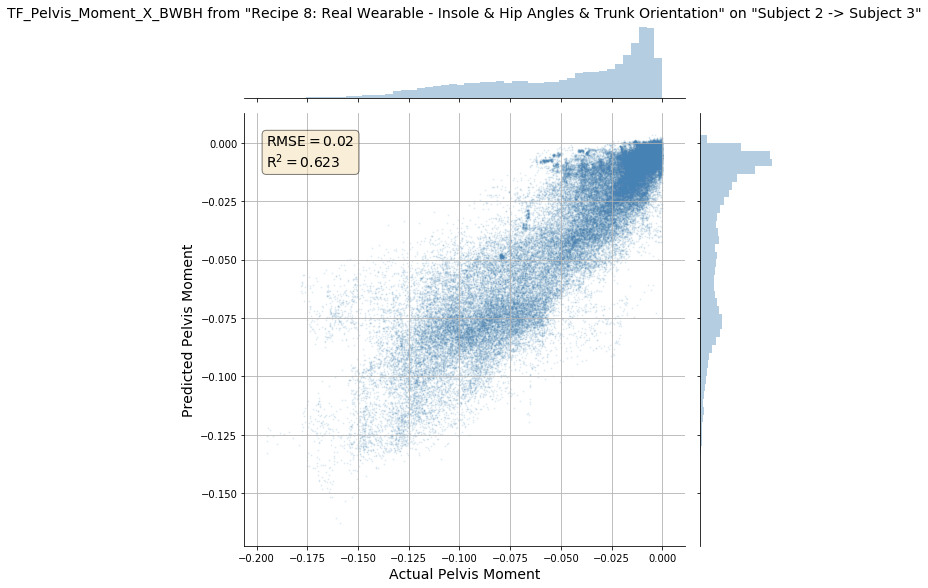

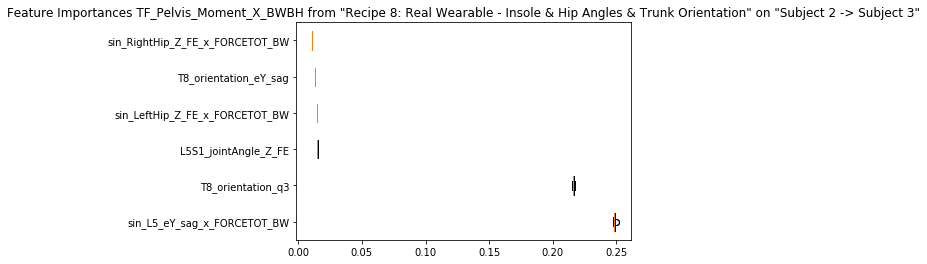

TF_Pelvis_Moment_X_BWBH from "Recipe 8: Real Wearable - Insole & Hip Angles & Trunk Orientation" on "Subject 2 -> Subject 3"
	R2=0.623


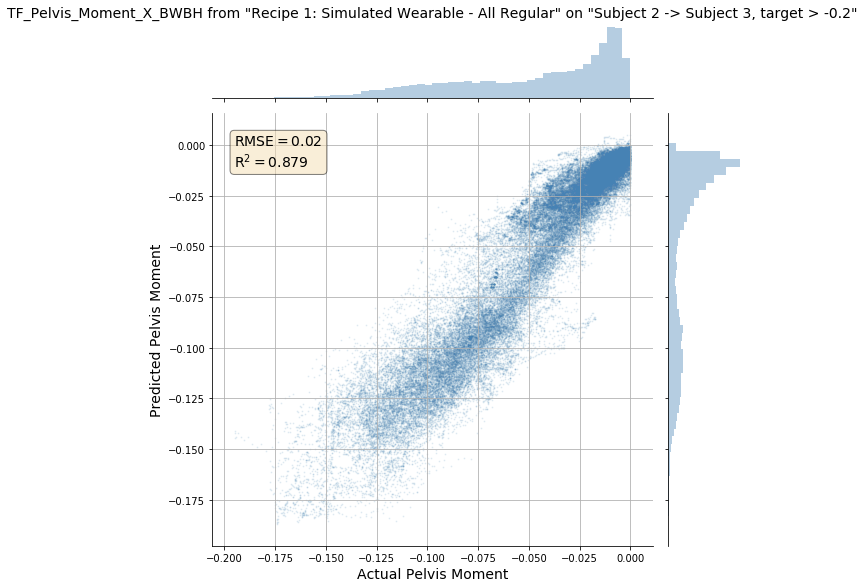

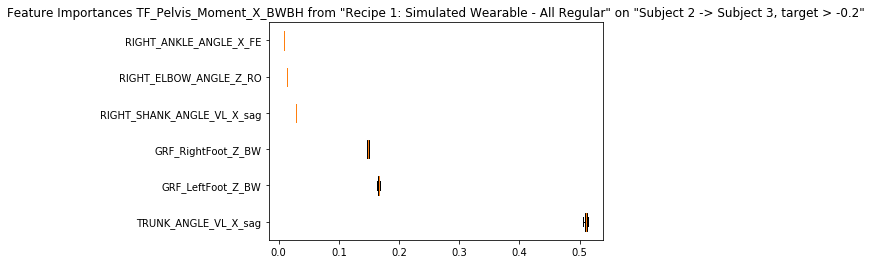

TF_Pelvis_Moment_X_BWBH from "Recipe 1: Simulated Wearable - All Regular" on "Subject 2 -> Subject 3, target > -0.2"
	R2=0.879


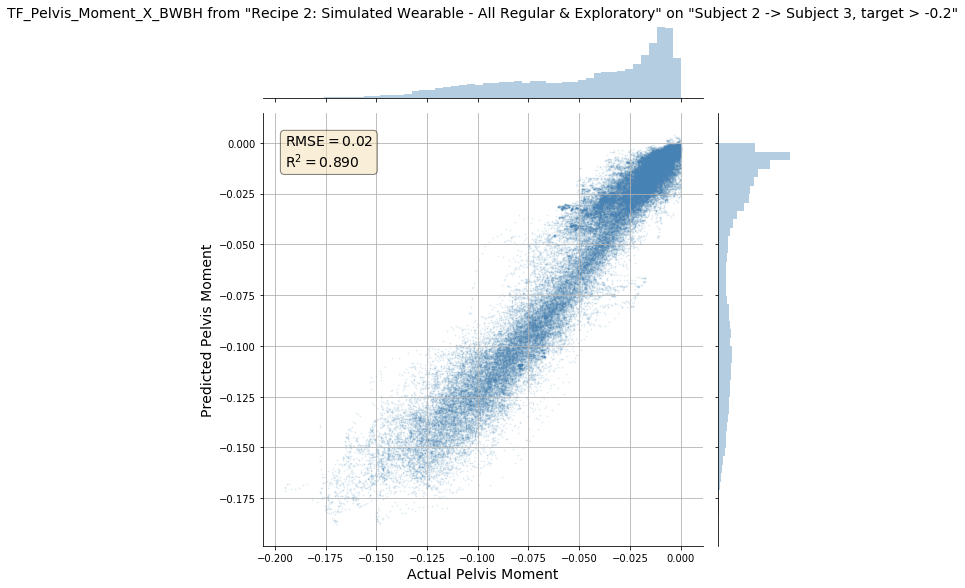

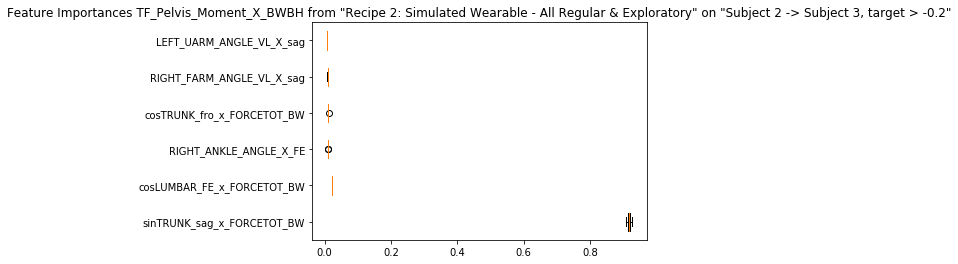

TF_Pelvis_Moment_X_BWBH from "Recipe 2: Simulated Wearable - All Regular & Exploratory" on "Subject 2 -> Subject 3, target > -0.2"
	R2=0.890


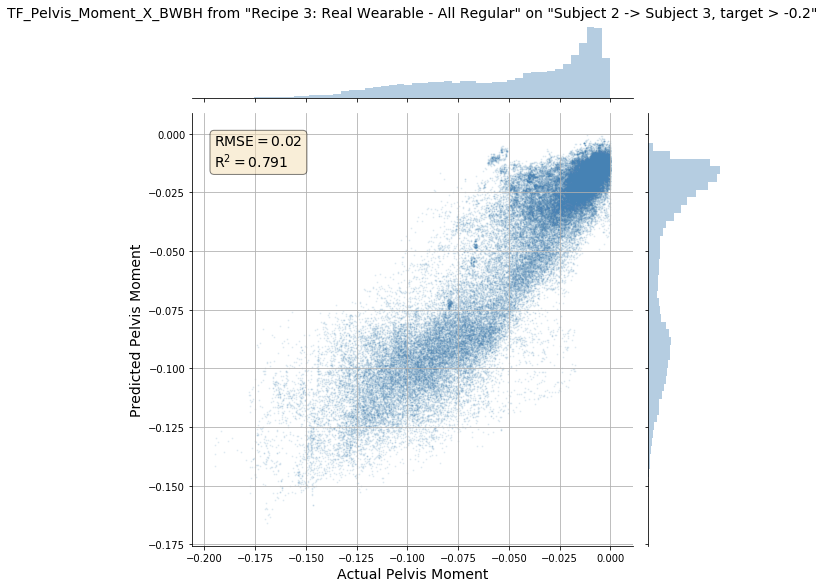

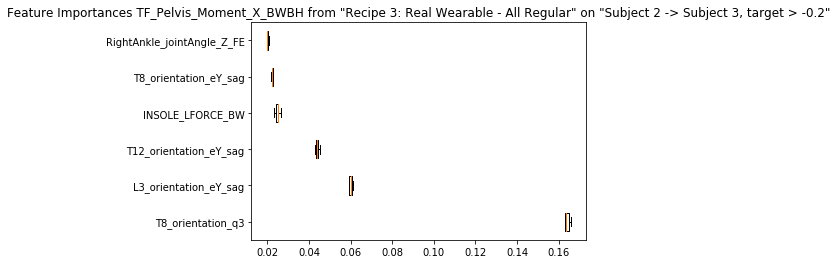

TF_Pelvis_Moment_X_BWBH from "Recipe 3: Real Wearable - All Regular" on "Subject 2 -> Subject 3, target > -0.2"
	R2=0.791


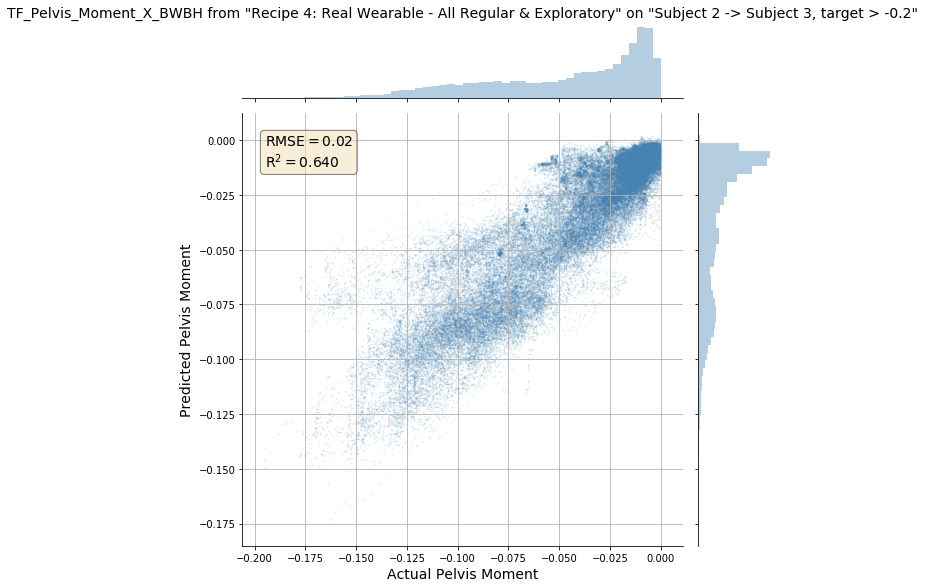

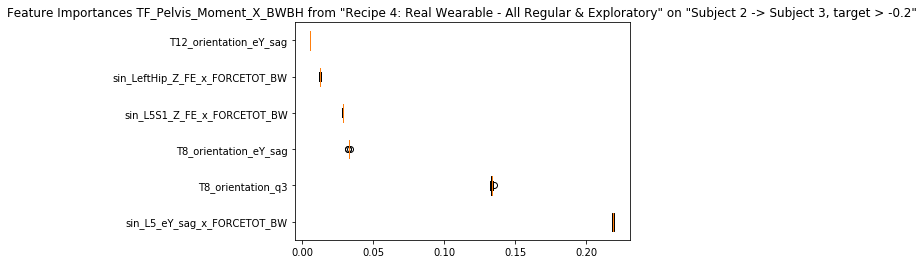

TF_Pelvis_Moment_X_BWBH from "Recipe 4: Real Wearable - All Regular & Exploratory" on "Subject 2 -> Subject 3, target > -0.2"
	R2=0.640


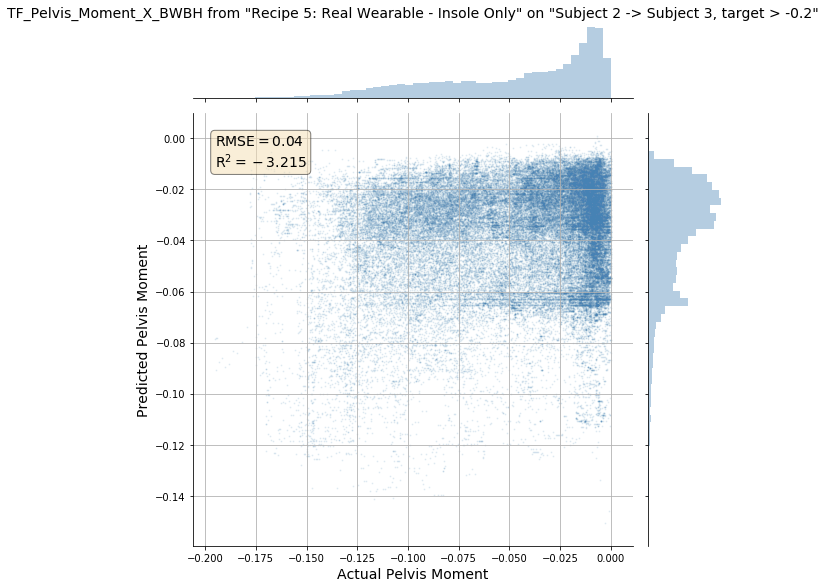

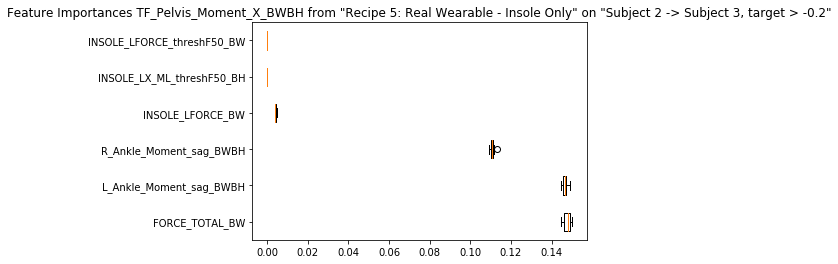

TF_Pelvis_Moment_X_BWBH from "Recipe 5: Real Wearable - Insole Only" on "Subject 2 -> Subject 3, target > -0.2"
	R2=-3.215


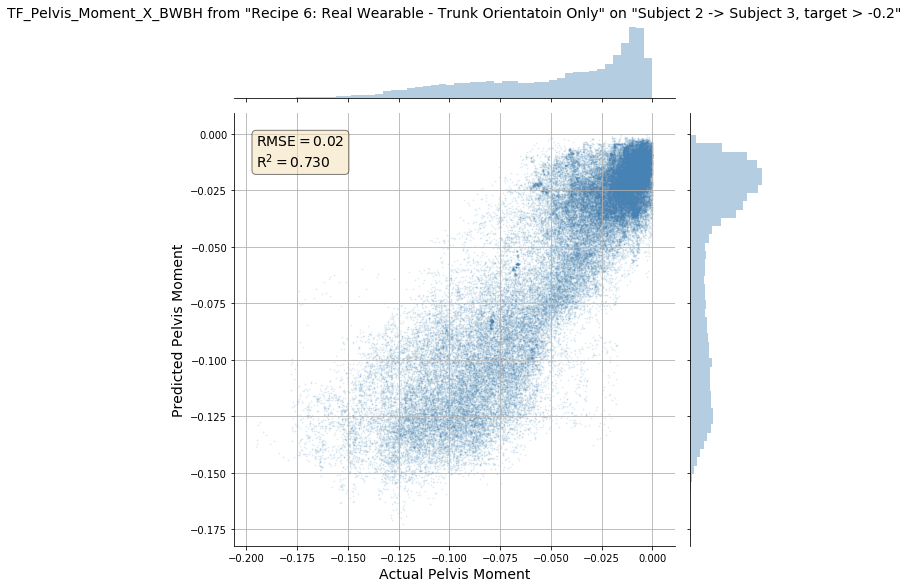

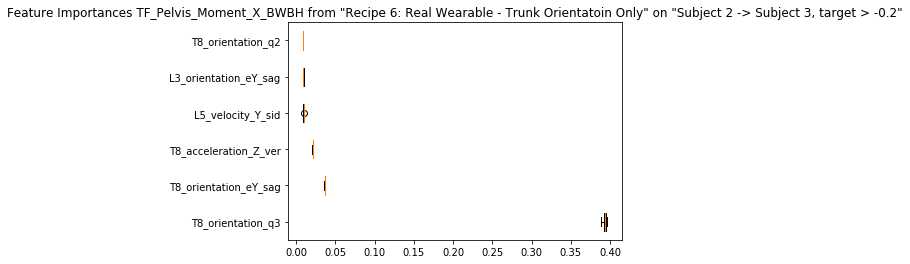

TF_Pelvis_Moment_X_BWBH from "Recipe 6: Real Wearable - Trunk Orientatoin Only" on "Subject 2 -> Subject 3, target > -0.2"
	R2=0.730


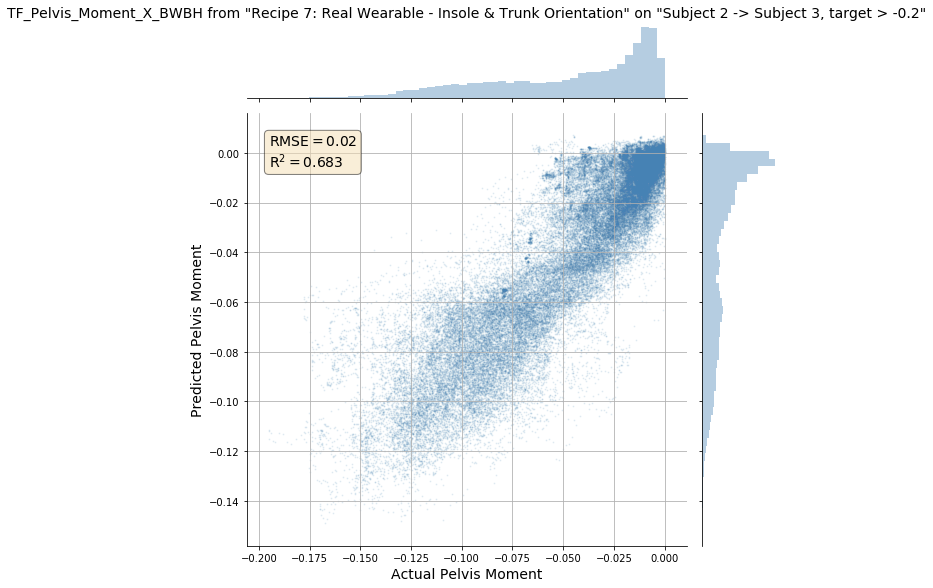

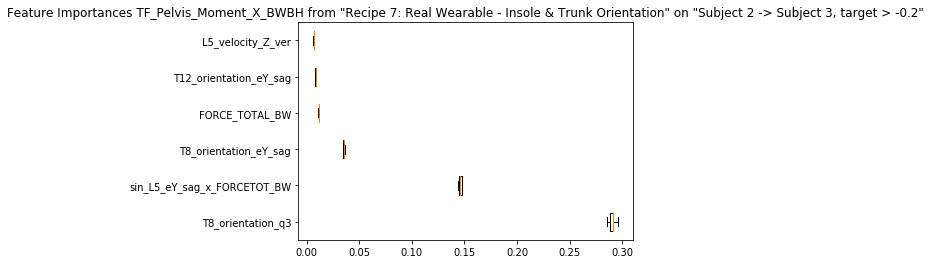

TF_Pelvis_Moment_X_BWBH from "Recipe 7: Real Wearable - Insole & Trunk Orientation" on "Subject 2 -> Subject 3, target > -0.2"
	R2=0.683


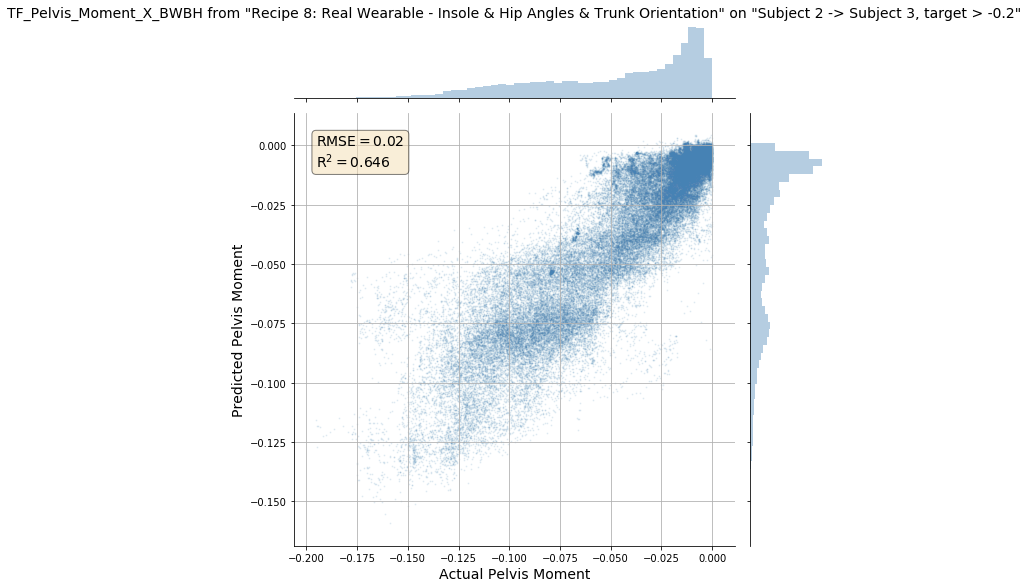

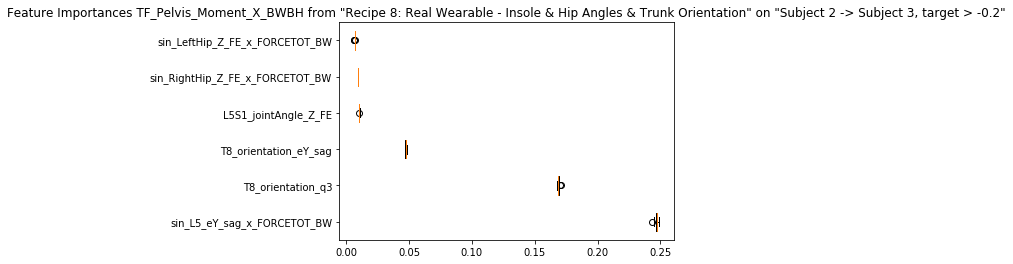

TF_Pelvis_Moment_X_BWBH from "Recipe 8: Real Wearable - Insole & Hip Angles & Trunk Orientation" on "Subject 2 -> Subject 3, target > -0.2"
	R2=0.646


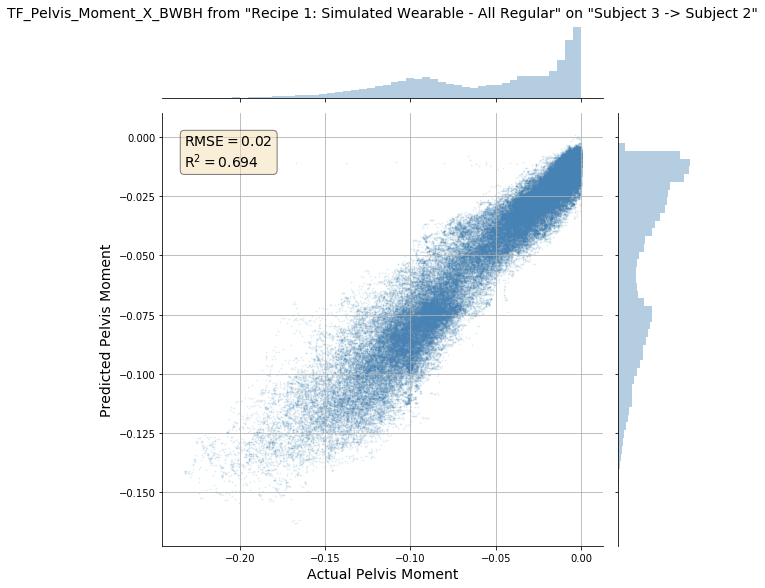

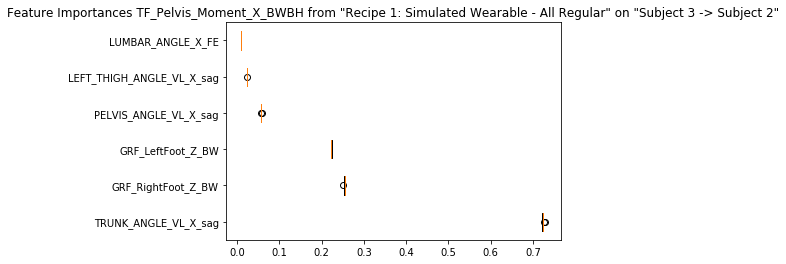

TF_Pelvis_Moment_X_BWBH from "Recipe 1: Simulated Wearable - All Regular" on "Subject 3 -> Subject 2"
	R2=0.694


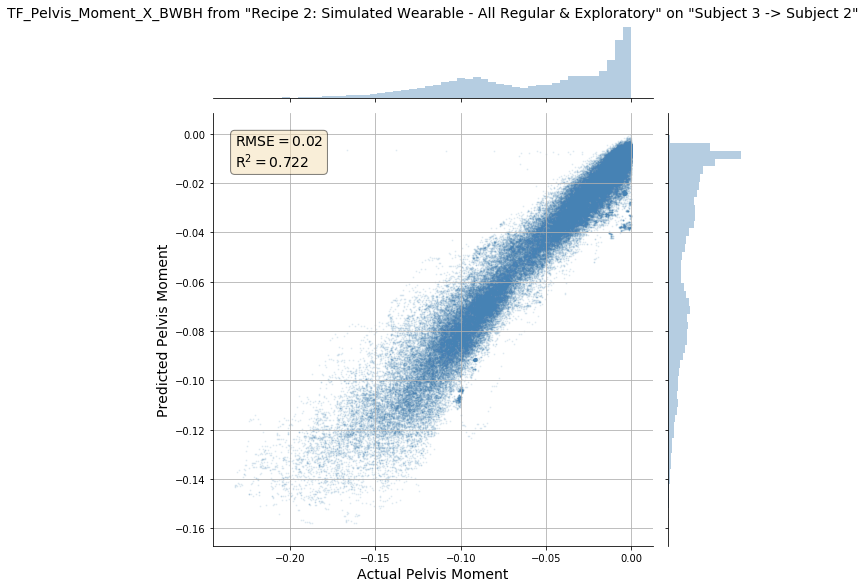

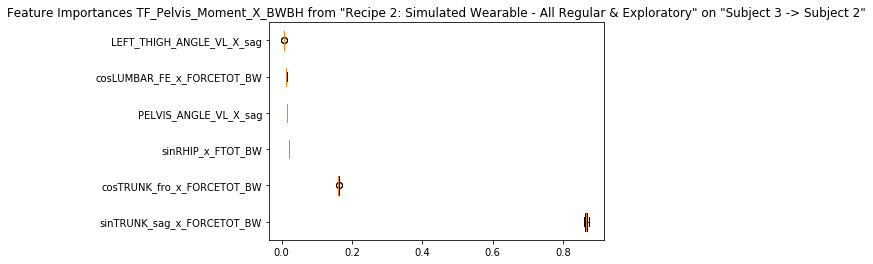

TF_Pelvis_Moment_X_BWBH from "Recipe 2: Simulated Wearable - All Regular & Exploratory" on "Subject 3 -> Subject 2"
	R2=0.722


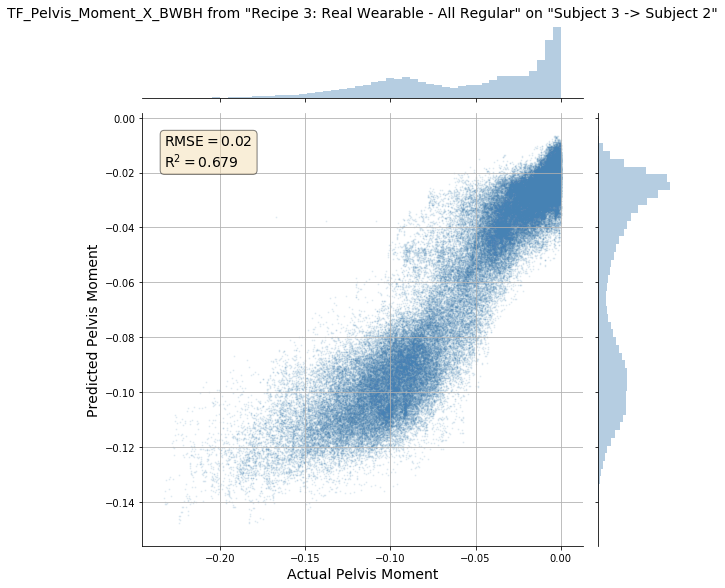

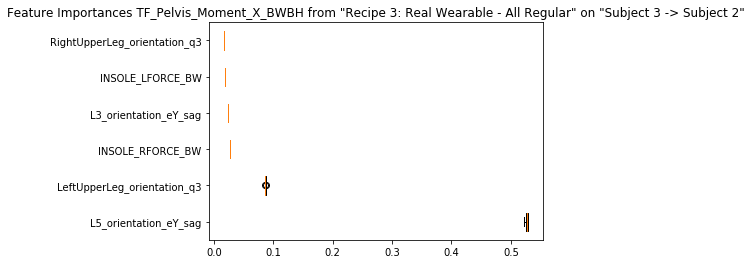

TF_Pelvis_Moment_X_BWBH from "Recipe 3: Real Wearable - All Regular" on "Subject 3 -> Subject 2"
	R2=0.679


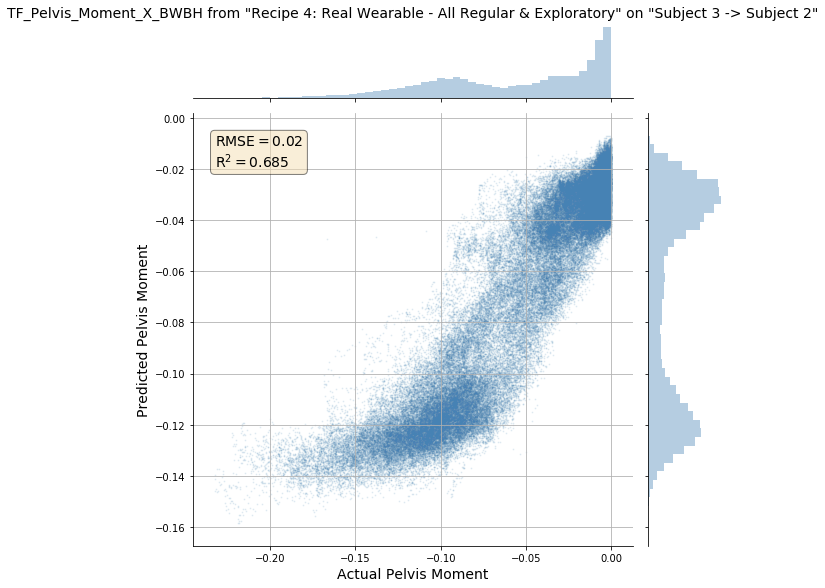

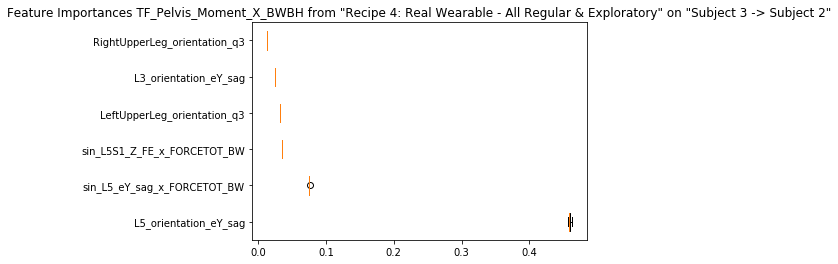

TF_Pelvis_Moment_X_BWBH from "Recipe 4: Real Wearable - All Regular & Exploratory" on "Subject 3 -> Subject 2"
	R2=0.685


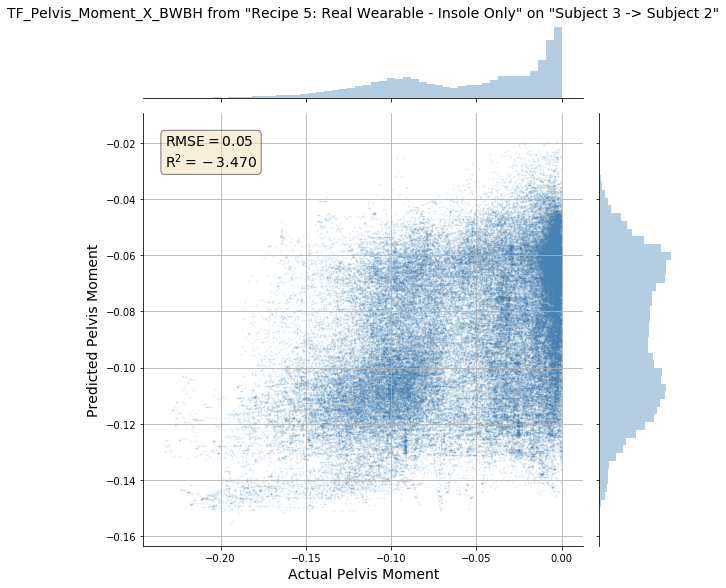

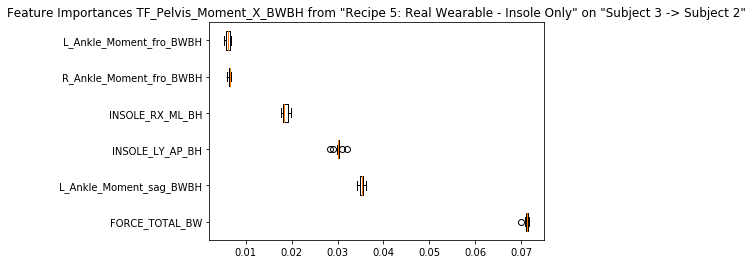

TF_Pelvis_Moment_X_BWBH from "Recipe 5: Real Wearable - Insole Only" on "Subject 3 -> Subject 2"
	R2=-3.470


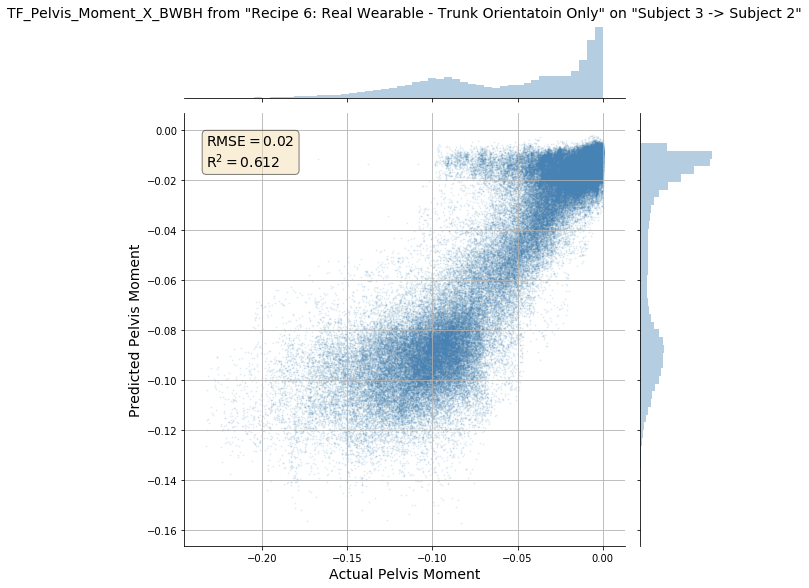

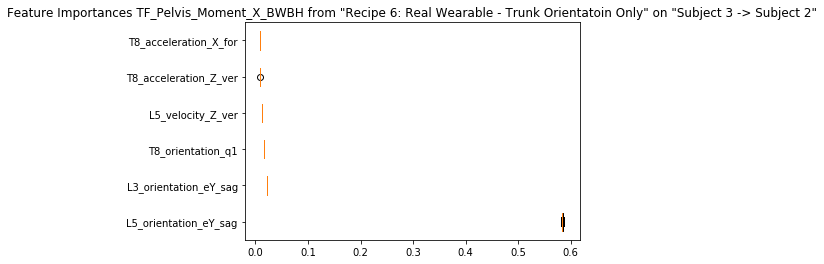

TF_Pelvis_Moment_X_BWBH from "Recipe 6: Real Wearable - Trunk Orientatoin Only" on "Subject 3 -> Subject 2"
	R2=0.612


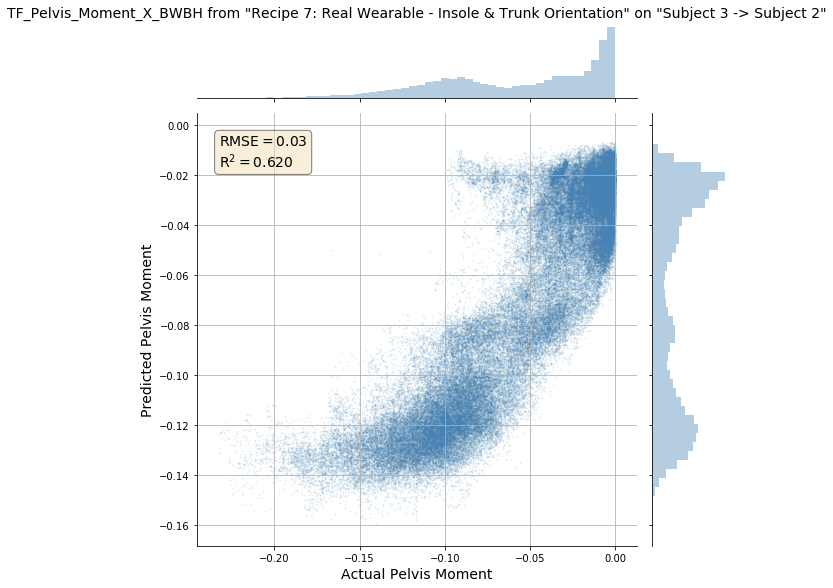

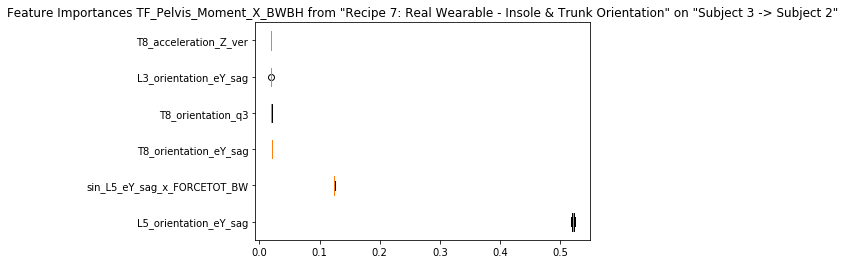

TF_Pelvis_Moment_X_BWBH from "Recipe 7: Real Wearable - Insole & Trunk Orientation" on "Subject 3 -> Subject 2"
	R2=0.620


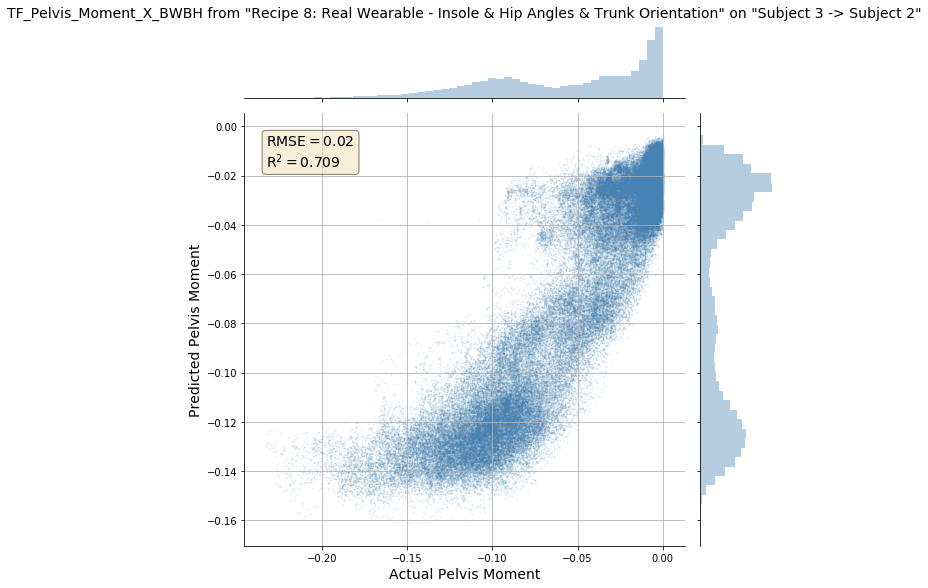

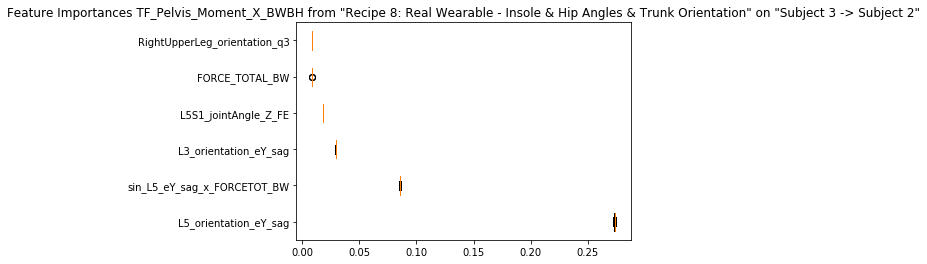

TF_Pelvis_Moment_X_BWBH from "Recipe 8: Real Wearable - Insole & Hip Angles & Trunk Orientation" on "Subject 3 -> Subject 2"
	R2=0.709


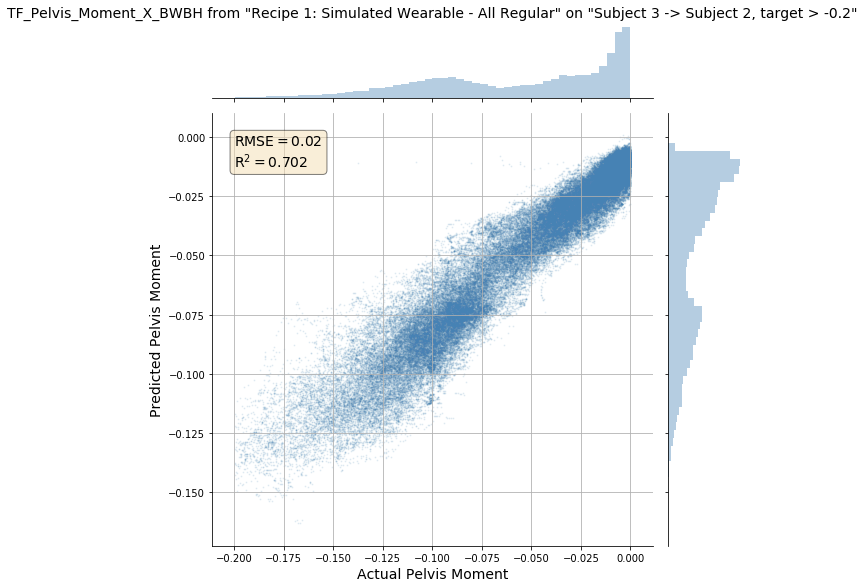

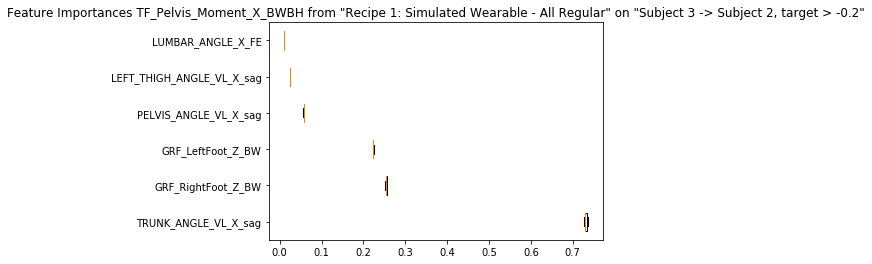

TF_Pelvis_Moment_X_BWBH from "Recipe 1: Simulated Wearable - All Regular" on "Subject 3 -> Subject 2, target > -0.2"
	R2=0.702


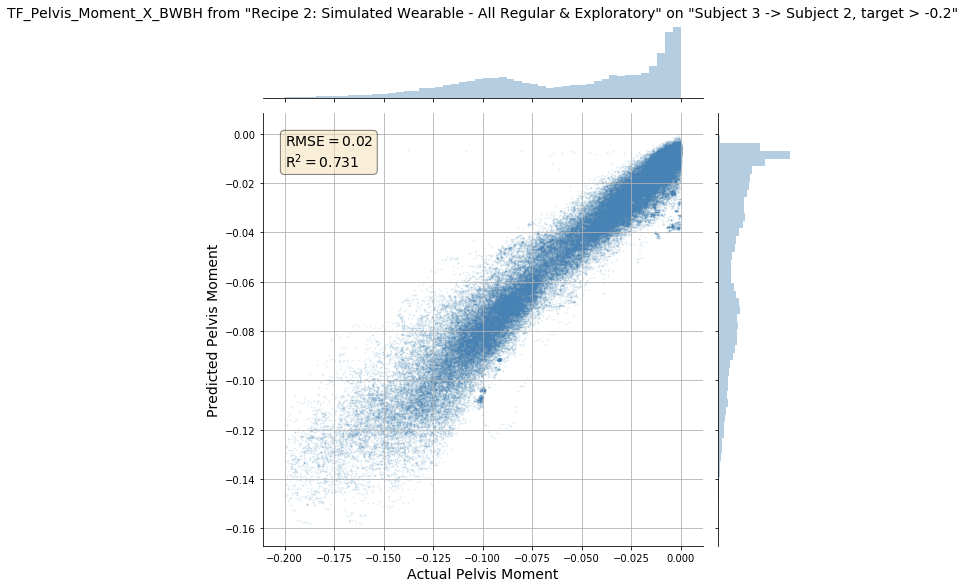

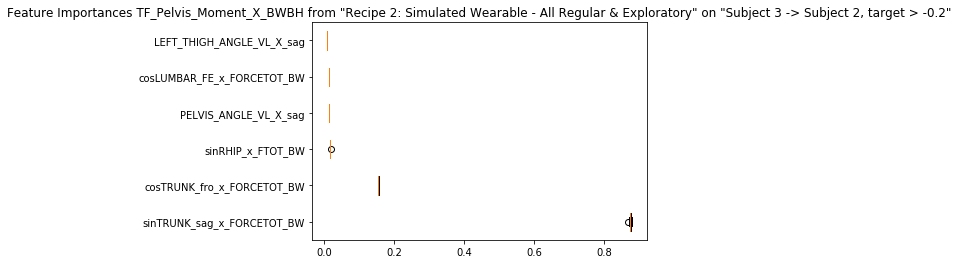

TF_Pelvis_Moment_X_BWBH from "Recipe 2: Simulated Wearable - All Regular & Exploratory" on "Subject 3 -> Subject 2, target > -0.2"
	R2=0.731


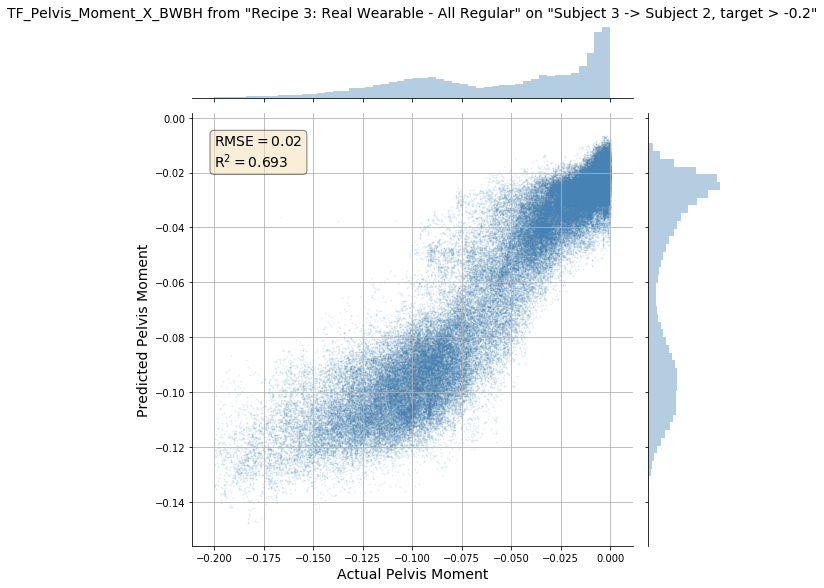

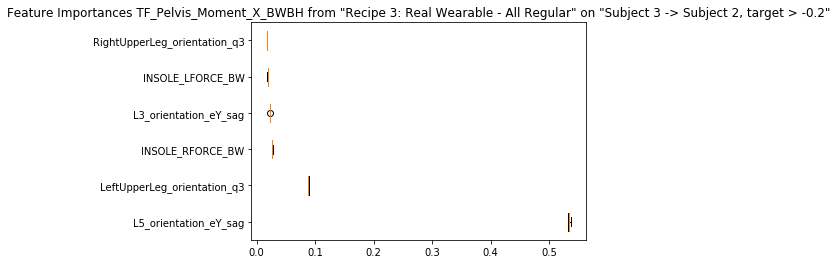

TF_Pelvis_Moment_X_BWBH from "Recipe 3: Real Wearable - All Regular" on "Subject 3 -> Subject 2, target > -0.2"
	R2=0.693


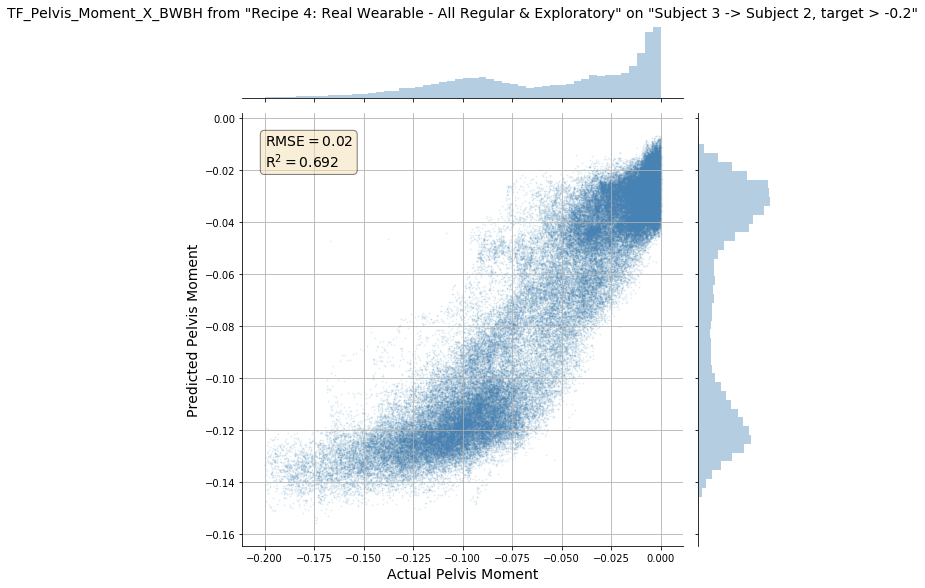

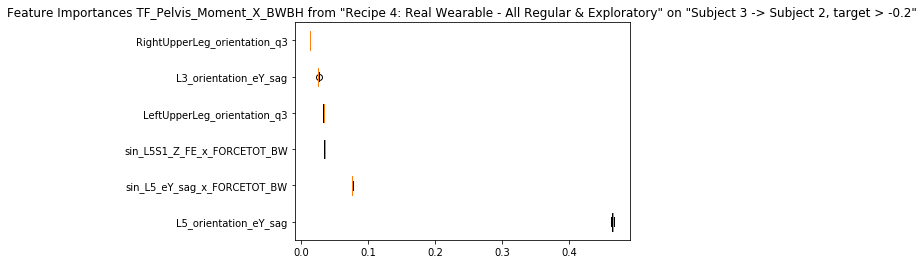

TF_Pelvis_Moment_X_BWBH from "Recipe 4: Real Wearable - All Regular & Exploratory" on "Subject 3 -> Subject 2, target > -0.2"
	R2=0.692


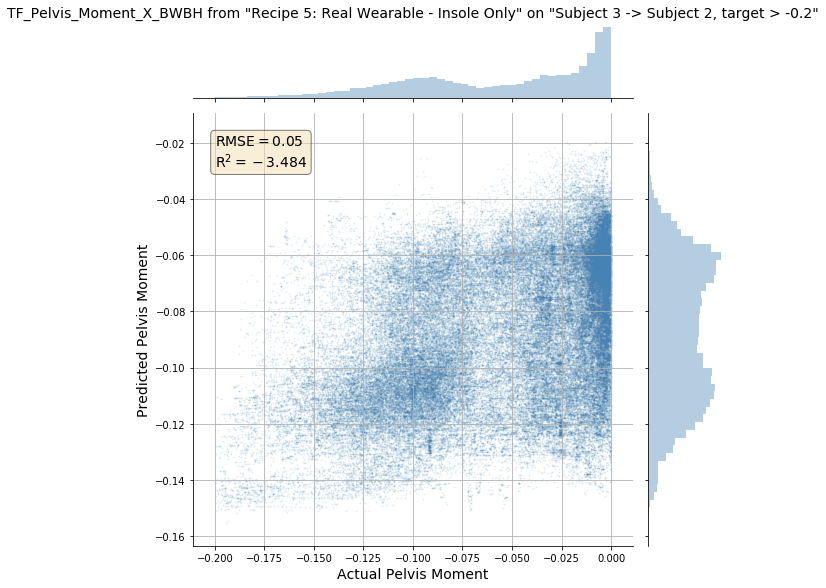

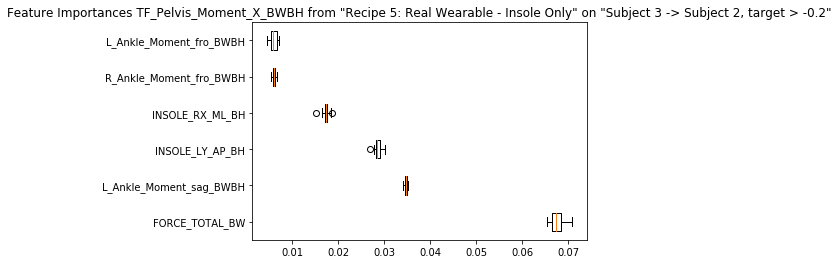

TF_Pelvis_Moment_X_BWBH from "Recipe 5: Real Wearable - Insole Only" on "Subject 3 -> Subject 2, target > -0.2"
	R2=-3.484


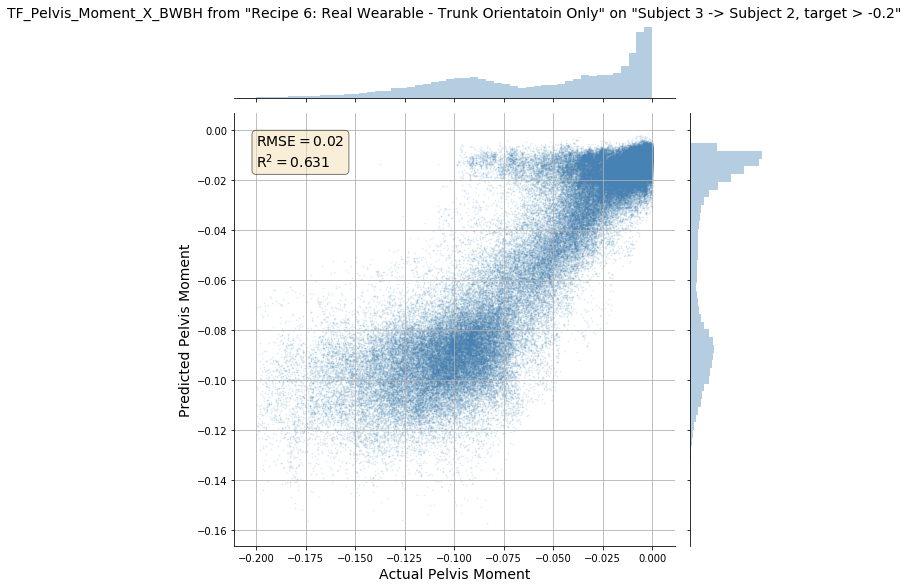

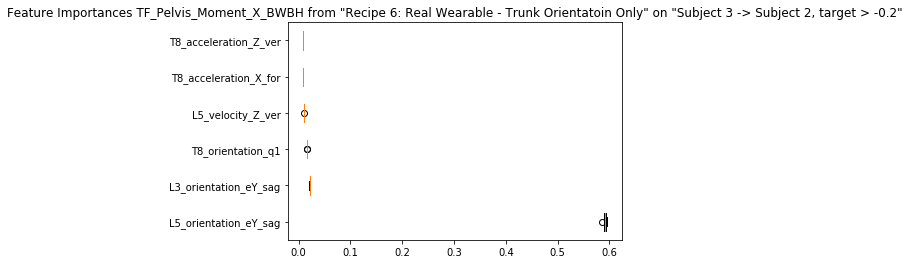

TF_Pelvis_Moment_X_BWBH from "Recipe 6: Real Wearable - Trunk Orientatoin Only" on "Subject 3 -> Subject 2, target > -0.2"
	R2=0.631


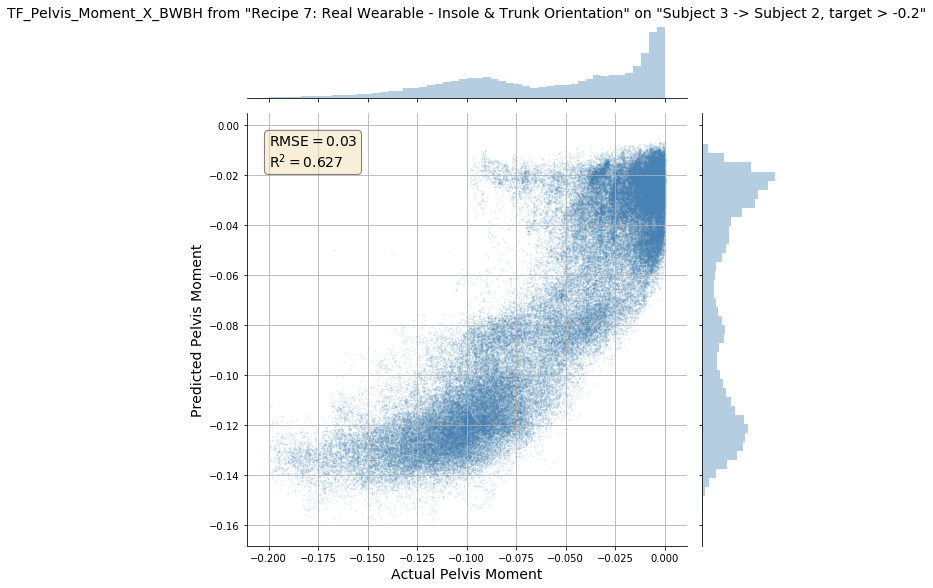

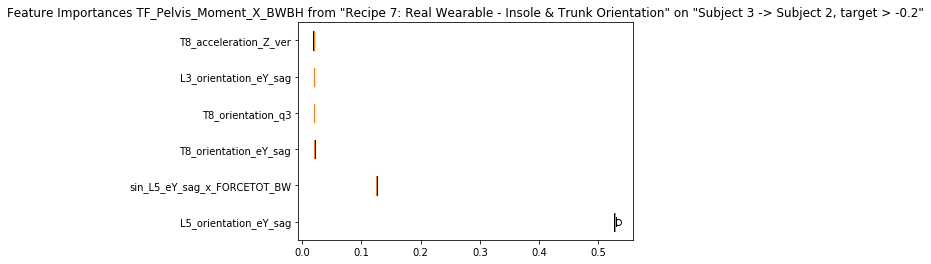

TF_Pelvis_Moment_X_BWBH from "Recipe 7: Real Wearable - Insole & Trunk Orientation" on "Subject 3 -> Subject 2, target > -0.2"
	R2=0.627


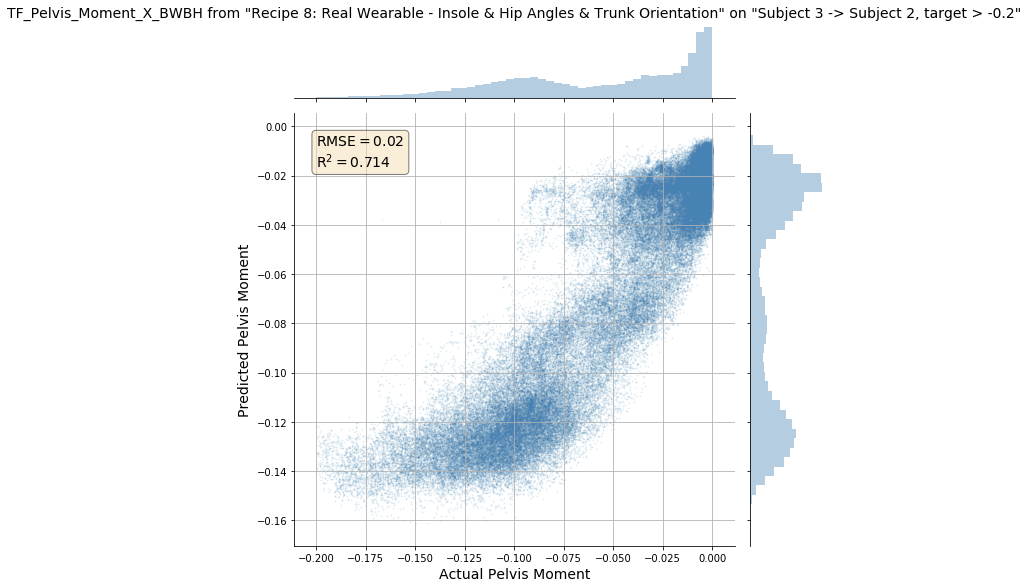

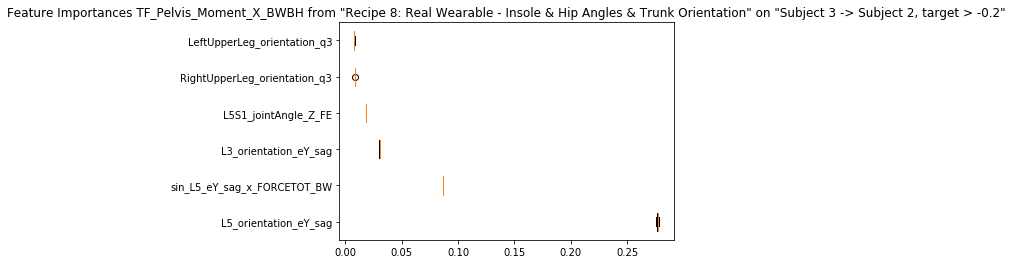

TF_Pelvis_Moment_X_BWBH from "Recipe 8: Real Wearable - Insole & Hip Angles & Trunk Orientation" on "Subject 3 -> Subject 2, target > -0.2"
	R2=0.714


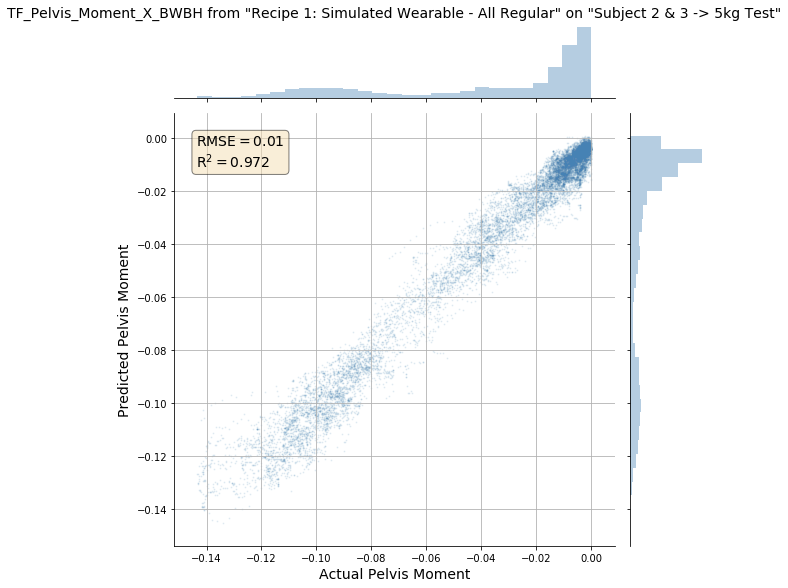

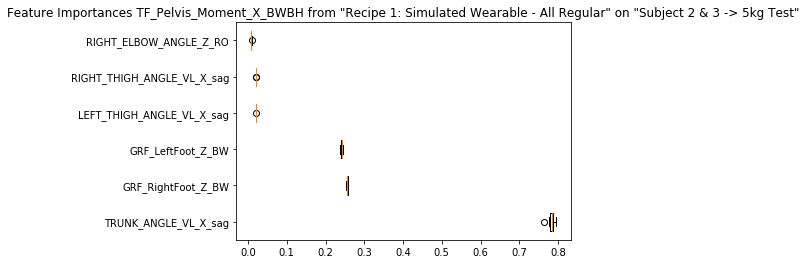

TF_Pelvis_Moment_X_BWBH from "Recipe 1: Simulated Wearable - All Regular" on "Subject 2 & 3 -> 5kg Test"
	R2=0.972


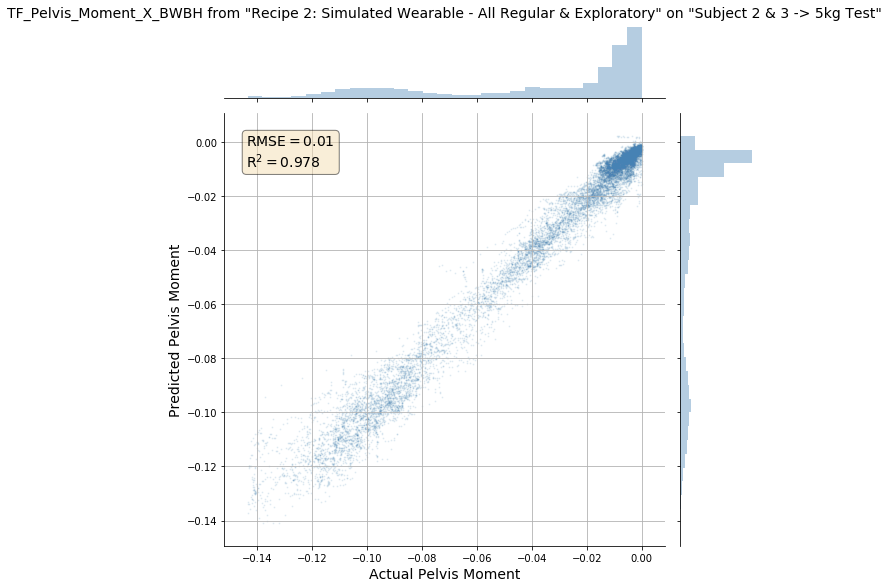

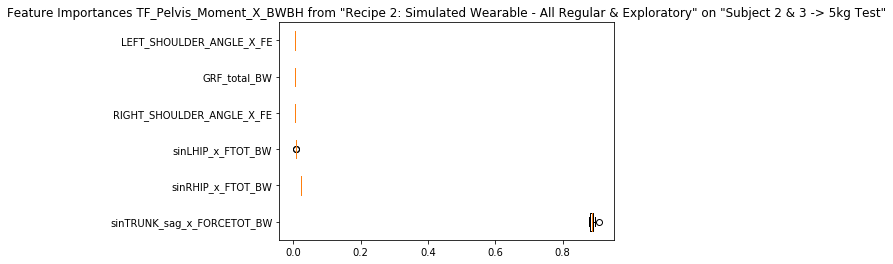

TF_Pelvis_Moment_X_BWBH from "Recipe 2: Simulated Wearable - All Regular & Exploratory" on "Subject 2 & 3 -> 5kg Test"
	R2=0.978


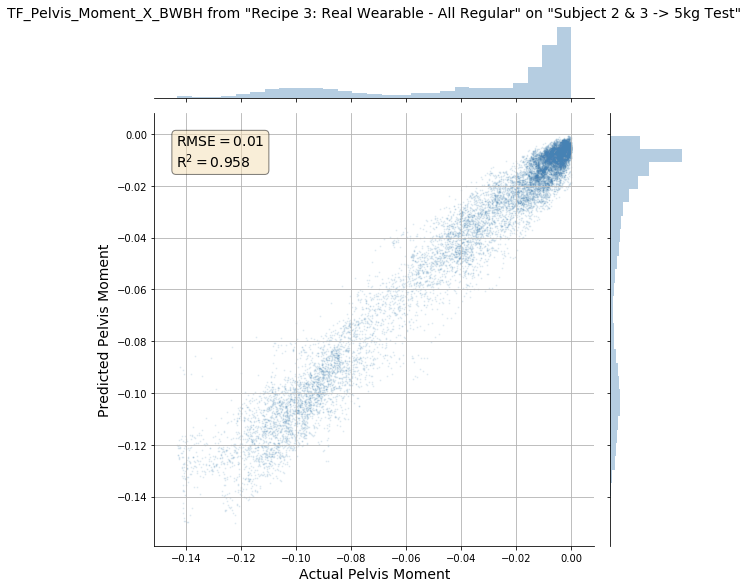

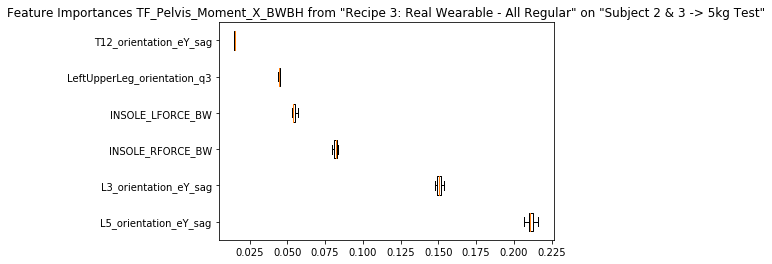

TF_Pelvis_Moment_X_BWBH from "Recipe 3: Real Wearable - All Regular" on "Subject 2 & 3 -> 5kg Test"
	R2=0.958


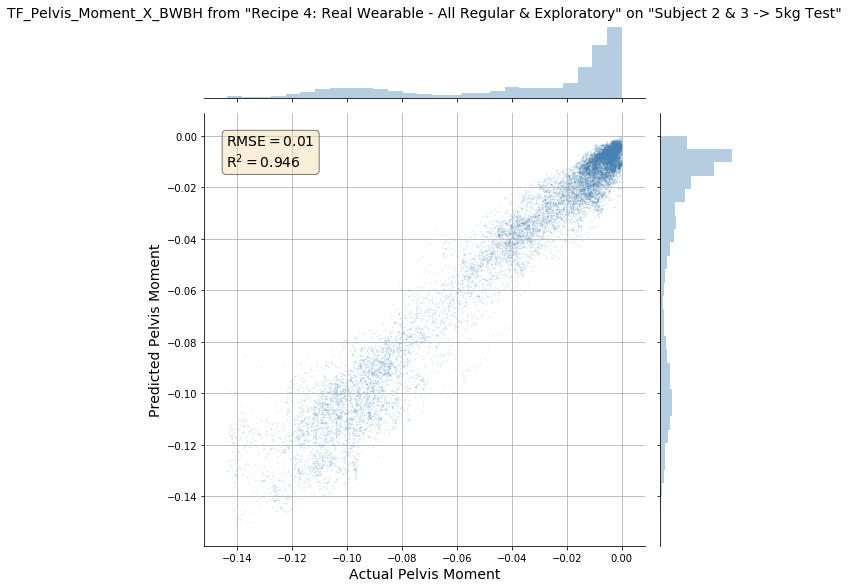

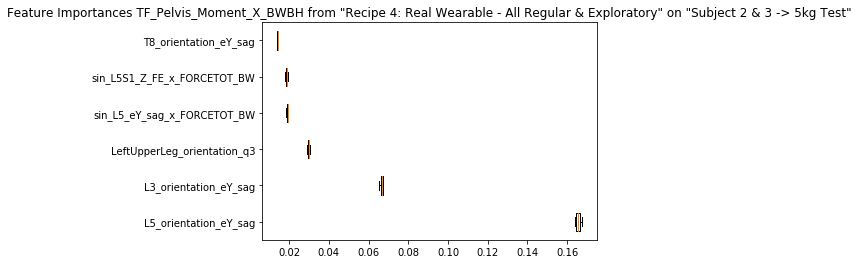

TF_Pelvis_Moment_X_BWBH from "Recipe 4: Real Wearable - All Regular & Exploratory" on "Subject 2 & 3 -> 5kg Test"
	R2=0.946


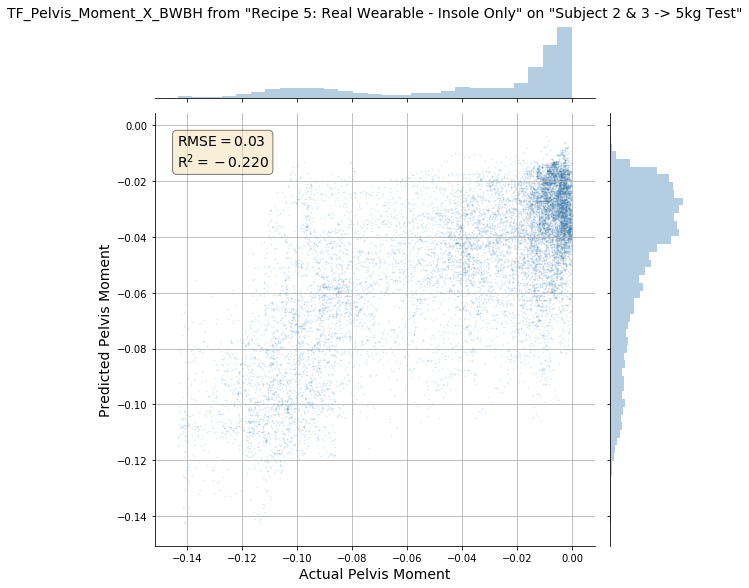

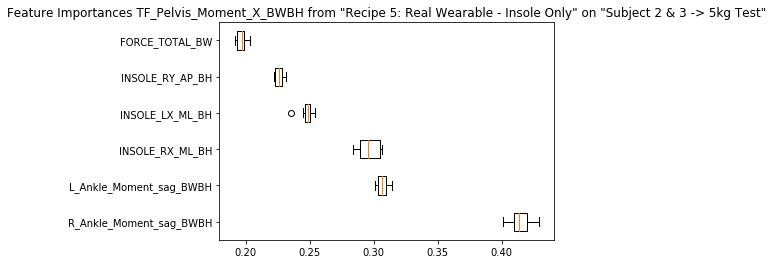

TF_Pelvis_Moment_X_BWBH from "Recipe 5: Real Wearable - Insole Only" on "Subject 2 & 3 -> 5kg Test"
	R2=-0.220


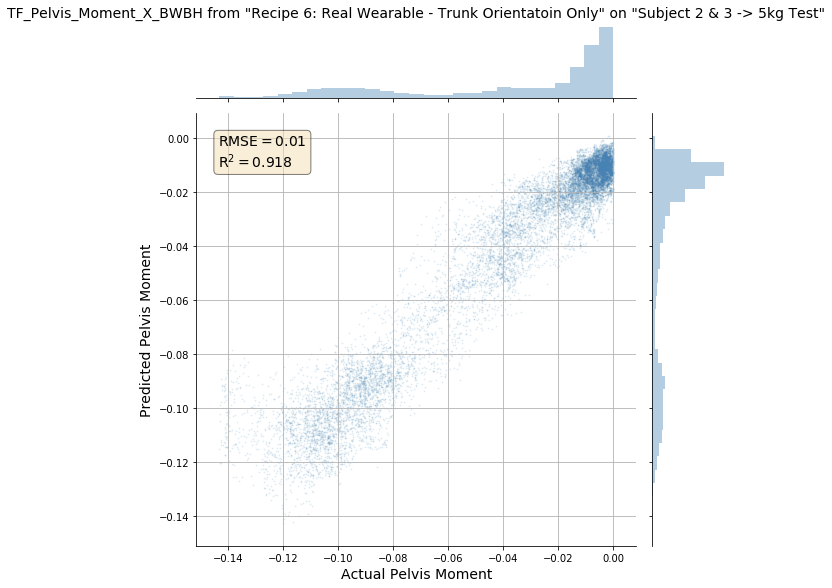

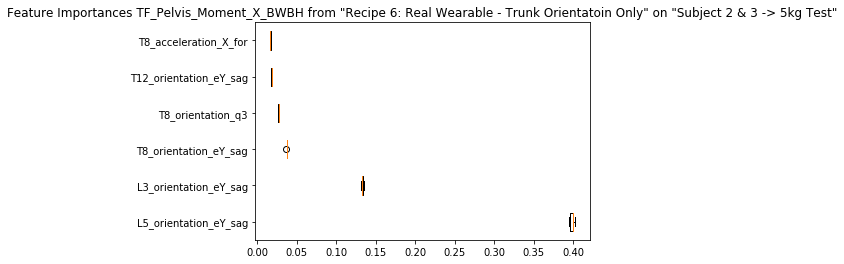

TF_Pelvis_Moment_X_BWBH from "Recipe 6: Real Wearable - Trunk Orientatoin Only" on "Subject 2 & 3 -> 5kg Test"
	R2=0.918


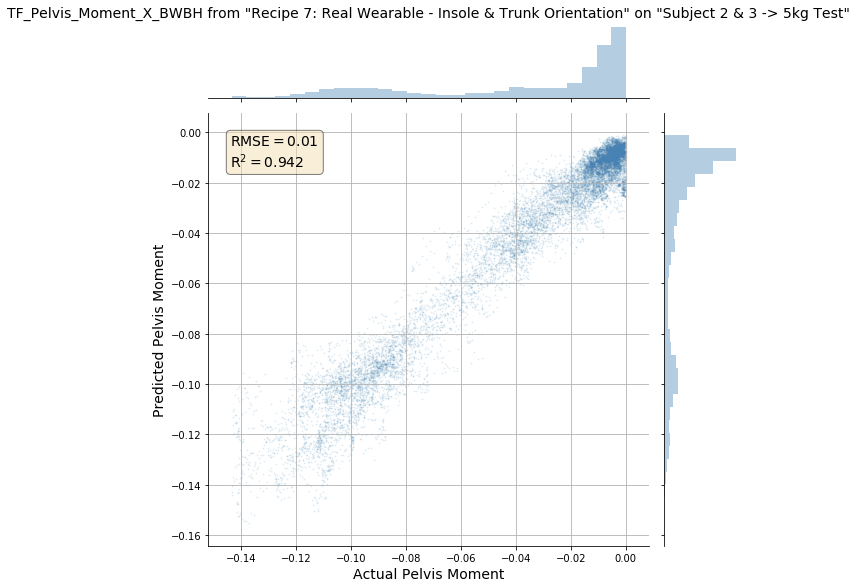

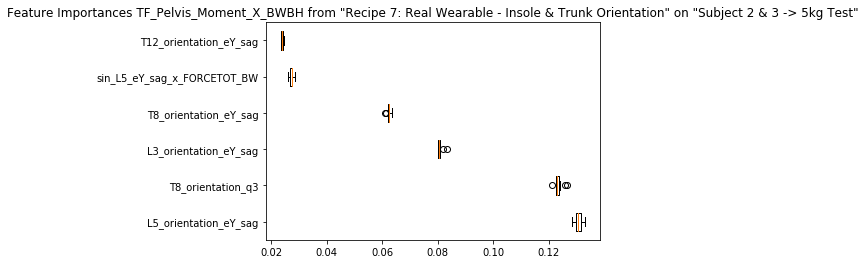

TF_Pelvis_Moment_X_BWBH from "Recipe 7: Real Wearable - Insole & Trunk Orientation" on "Subject 2 & 3 -> 5kg Test"
	R2=0.942


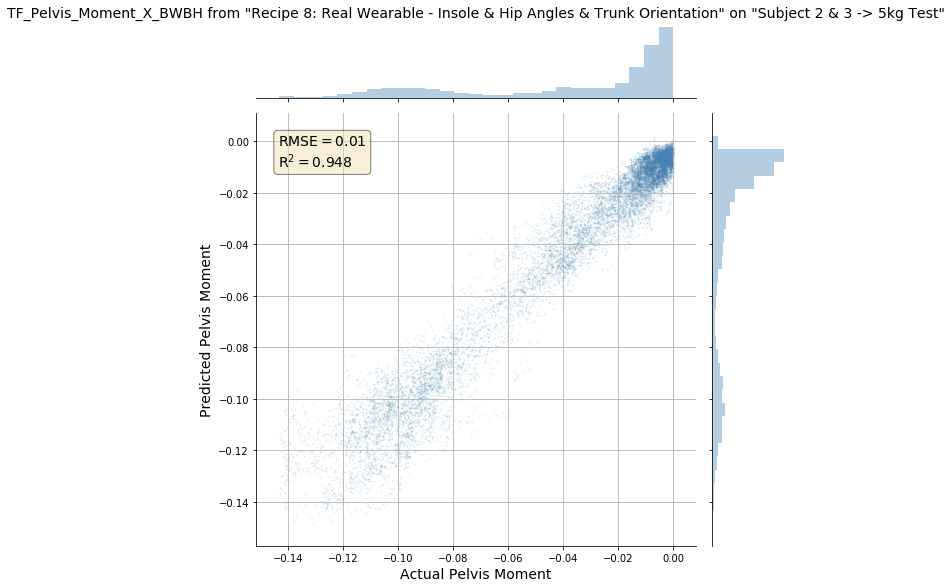

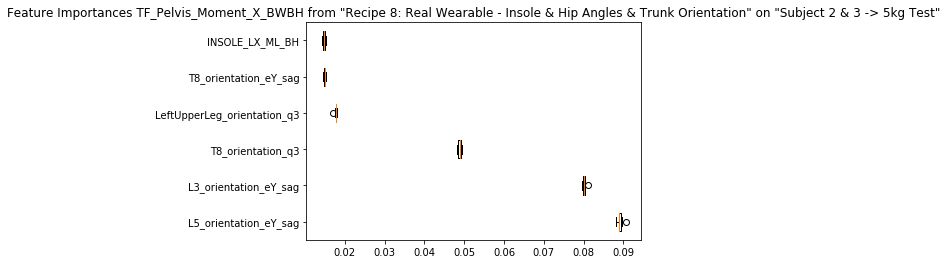

TF_Pelvis_Moment_X_BWBH from "Recipe 8: Real Wearable - Insole & Hip Angles & Trunk Orientation" on "Subject 2 & 3 -> 5kg Test"
	R2=0.948


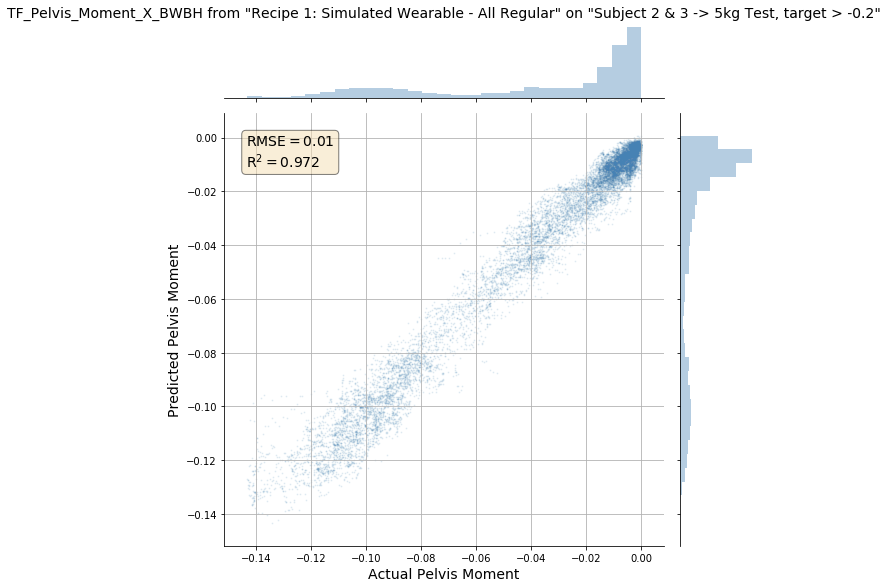

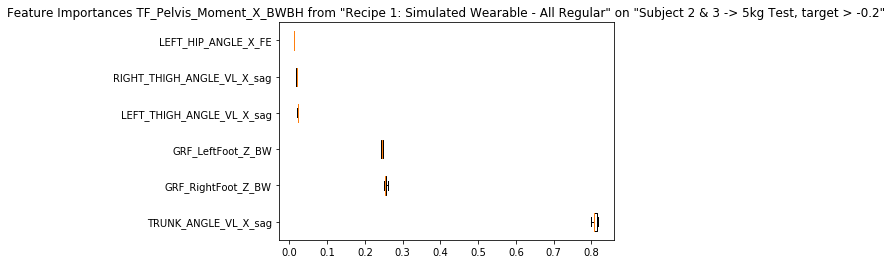

TF_Pelvis_Moment_X_BWBH from "Recipe 1: Simulated Wearable - All Regular" on "Subject 2 & 3 -> 5kg Test, target > -0.2"
	R2=0.972


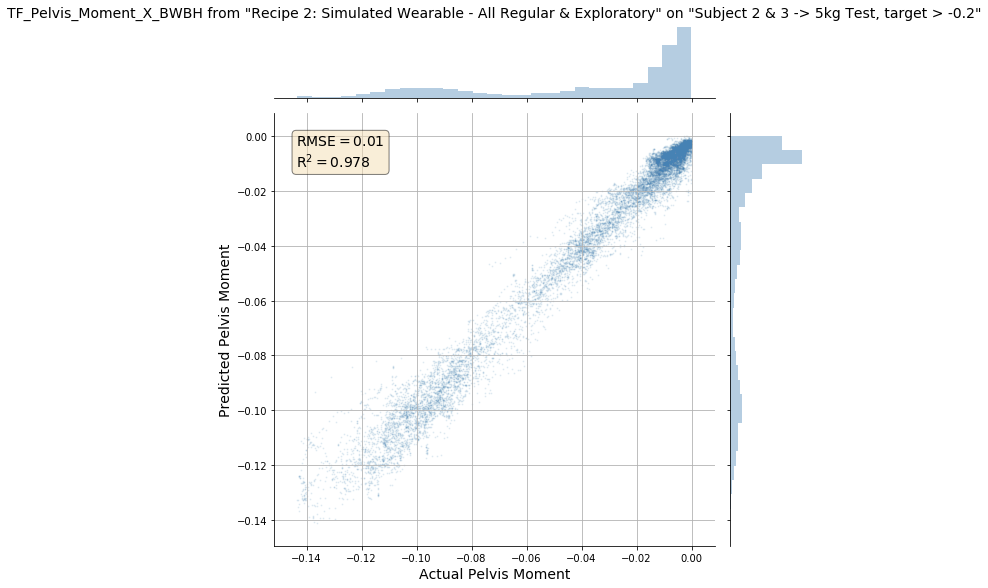

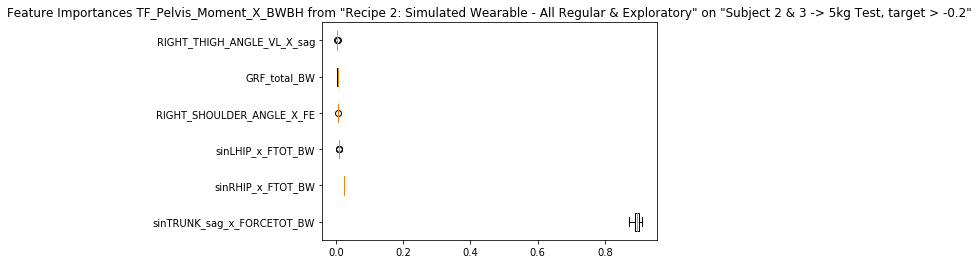

TF_Pelvis_Moment_X_BWBH from "Recipe 2: Simulated Wearable - All Regular & Exploratory" on "Subject 2 & 3 -> 5kg Test, target > -0.2"
	R2=0.978


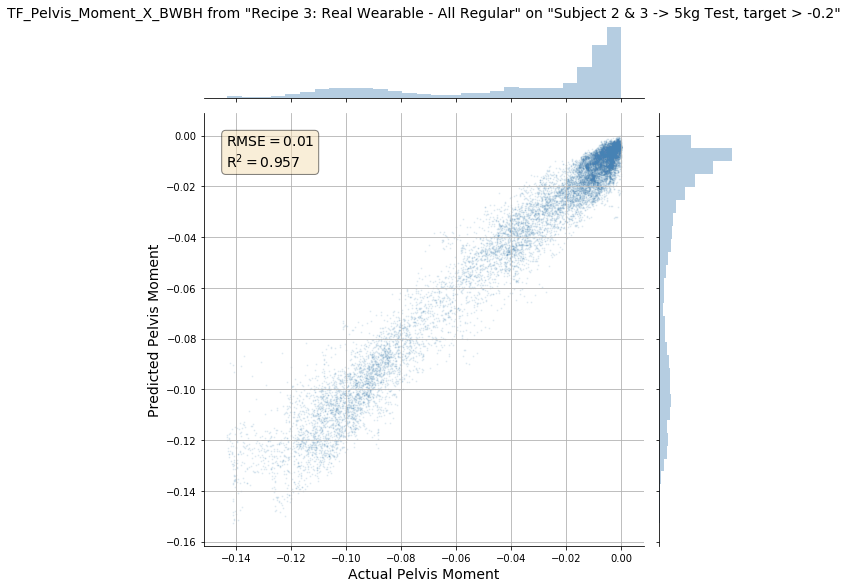

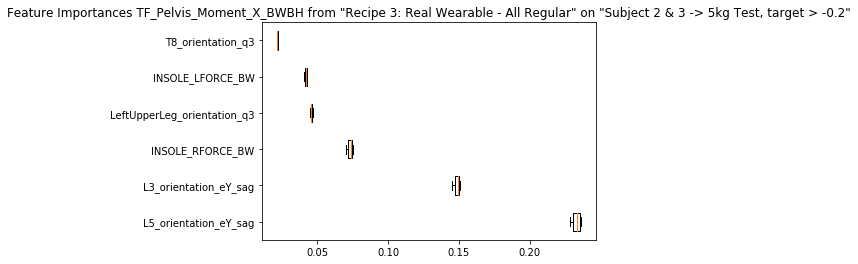

TF_Pelvis_Moment_X_BWBH from "Recipe 3: Real Wearable - All Regular" on "Subject 2 & 3 -> 5kg Test, target > -0.2"
	R2=0.957


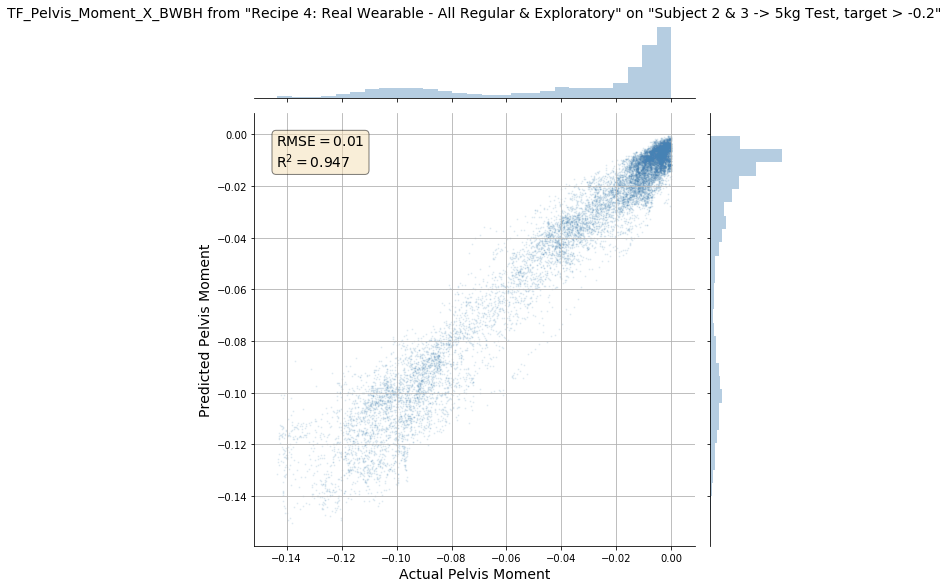

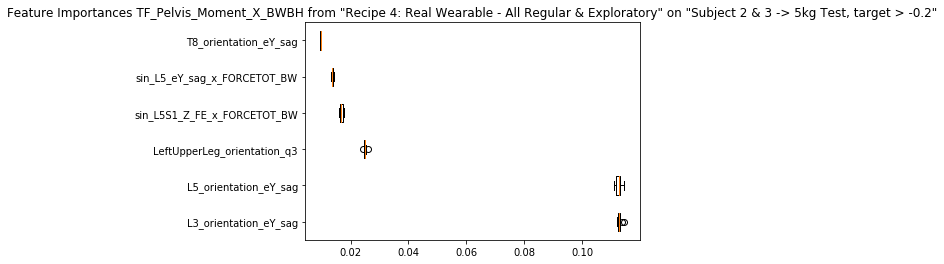

TF_Pelvis_Moment_X_BWBH from "Recipe 4: Real Wearable - All Regular & Exploratory" on "Subject 2 & 3 -> 5kg Test, target > -0.2"
	R2=0.947


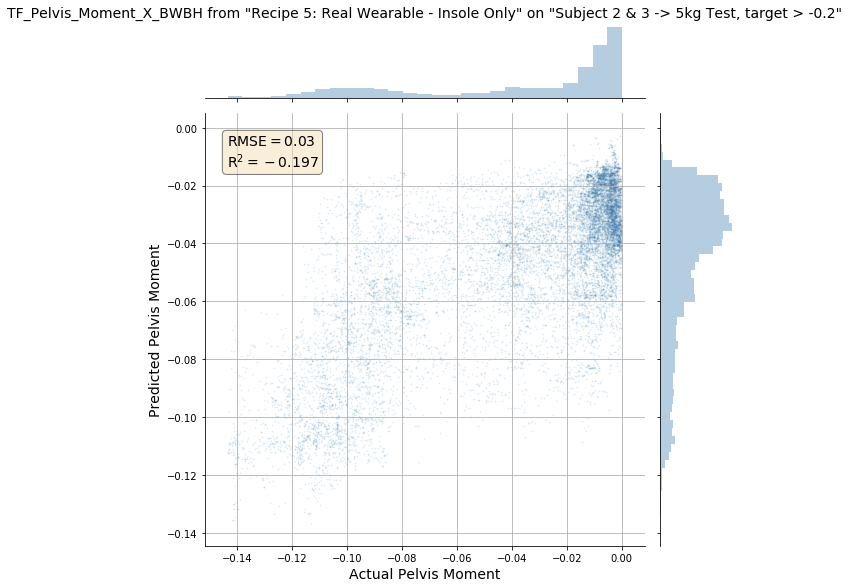

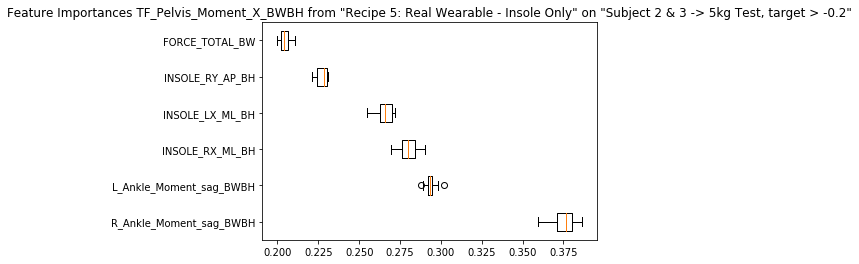

TF_Pelvis_Moment_X_BWBH from "Recipe 5: Real Wearable - Insole Only" on "Subject 2 & 3 -> 5kg Test, target > -0.2"
	R2=-0.197


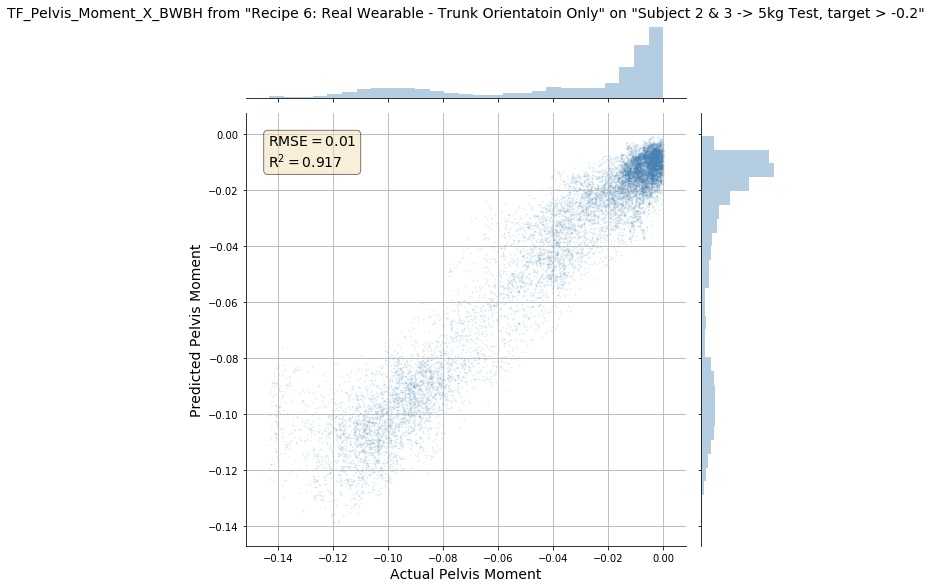

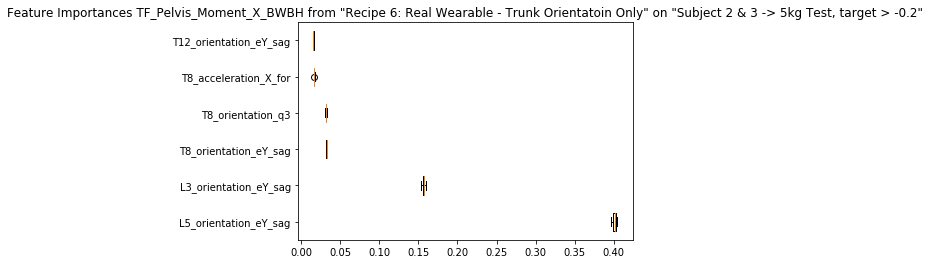

TF_Pelvis_Moment_X_BWBH from "Recipe 6: Real Wearable - Trunk Orientatoin Only" on "Subject 2 & 3 -> 5kg Test, target > -0.2"
	R2=0.917


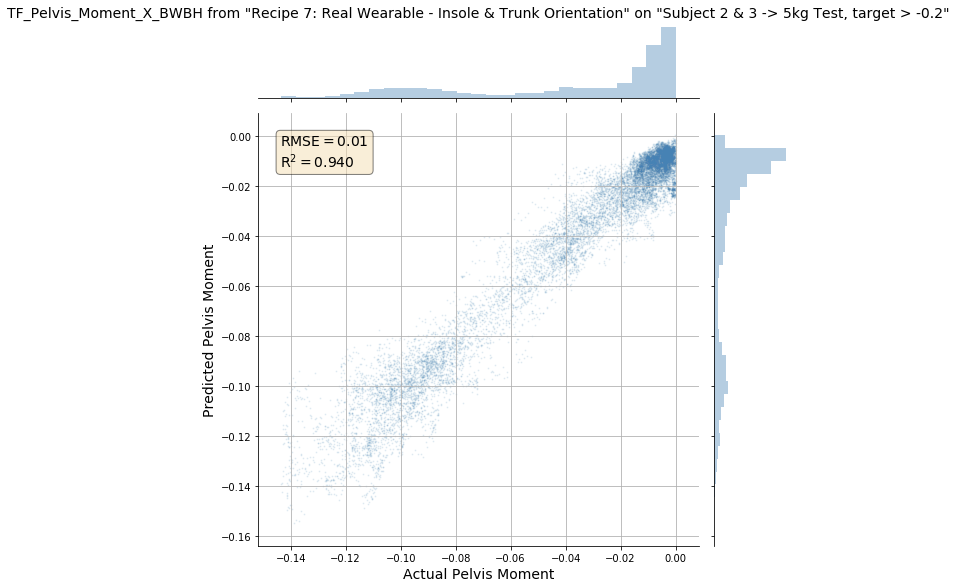

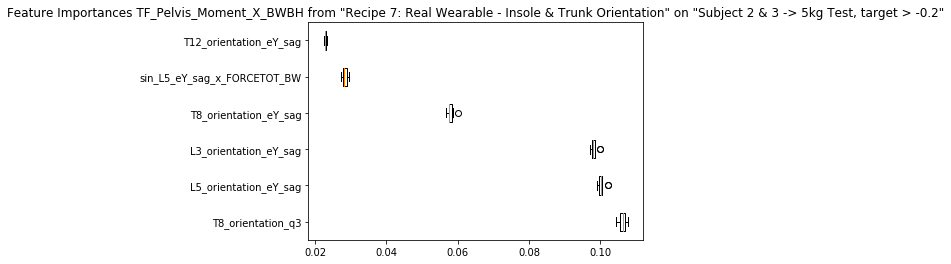

TF_Pelvis_Moment_X_BWBH from "Recipe 7: Real Wearable - Insole & Trunk Orientation" on "Subject 2 & 3 -> 5kg Test, target > -0.2"
	R2=0.940


In [ ]:
def train_model(X_train, y_train):
    model = pipeline.Pipeline([
        ('scaler', preprocessing.StandardScaler()),
        ('gboost', ensemble.HistGradientBoostingRegressor())
    ]).fit(X_train, y_train)
    return model
    
def evaluate_model(title, model, X_test, y_test, show_plot=False, show_importance=False):
    y_test_pred = model.predict(X_test)
    
    # Quantitative results
    rmse = np.sqrt(metrics.mean_squared_error(y_test_pred, y_test))
    r2 = metrics.r2_score(y_test_pred, y_test)
    
    if show_plot:
        ax = sns.jointplot(y_test, y_test_pred, alpha=0.1, s=1.0, color="steelblue", height=8)
        ax.set_axis_labels("Actual Pelvis Moment", 'Predicted Pelvis Moment', fontsize=14)
        ax.ax_joint.grid()
        ax.ax_marg_x.set_title(title, fontsize=14)

        summary = '\n'.join((
            r"$\mathrm{RMSE}=%.2f$" % (rmse,),
            r"$\mathrm{R}^2=%.3f$" % (r2,)
        ))

        props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
        ax.ax_joint.text(0.05, 0.95, summary, transform=ax.ax_joint.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)
        plt.show()
        
    if show_importance:
        feature_importances = inspection.permutation_importance(model, 
                                           X_test, 
                                           y_test, 
                                           n_repeats=10, n_jobs=-1)
        top_idxs = feature_importances.importances_mean.argsort()[::-1][:6]
        fig, ax = plt.subplots()
        ax.boxplot(feature_importances.importances[top_idxs].T,
               vert=False, labels=[predictor_short_name(X_test.columns[idx]) for idx in top_idxs])
        ax.set_title("Feature Importances " + title)
        #fig.tight_layout()
        plt.show()
    
    return r2

warnings.filterwarnings('ignore')
results = {}
for train_test_set_name, (df_train, df_test) in train_test_sets.items():
    for feature_set_name, feature_names in feature_sets.items():
        title = f'{target_name} from "{feature_set_name}" on "{train_test_set_name}"'
        model = train_model(df_train[feature_names], df_train[target_name])
        r2 = evaluate_model(title, model, df_test[feature_names], df_test[target_name], True, True)
        print(f"{title}\n\tR2={r2:.3f}")
        results.setdefault(train_test_set_name, {})[feature_set_name] = r2
warnings.filterwarnings('default')


In [ ]:
with pd.ExcelWriter('CPAC10S_S02_S03 - Results.xlsx') as writer:
    pd.DataFrame(results).to_excel(writer, sheet_name='Recipes')